In [ ]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, Concatenate
from keras.layers import LSTM, Embedding, Bidirectional, GRU
from keras.layers import SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import pickle
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import collections
from sklearn.utils.class_weight import compute_class_weight
from gensim import models

In [ ]:
from gensim import models
path = '/content/drive/MyDrive/ABSA'

In [ ]:
import kagglehub
datasetfull_path = kagglehub.dataset_download('baolamlam/datasetfull')

In [ ]:
/kaggle/input/datasetfull/DataProcessed-20241215T075659Z-001/DataProcessed/dev_processed.csv

In [ ]:
df_train = pd.read_csv("/kaggle/input/datasetfull/DataProcessed-20241215T075659Z-001/DataProcessed/train_processed.csv")
df_val = pd.read_csv("/kaggle/input/datasetfull/DataProcessed-20241215T075659Z-001/DataProcessed/dev_processed.csv")
df_test = pd.read_csv("/kaggle/input/datasetfull/DataProcessed-20241215T075659Z-001/DataProcessed/test_processed.csv")

In [ ]:
df_train

,Unnamed: 0,character,content,scene,sound,Cmt,processed_cmt
0,0,X,O,X,P,"nhạc phim hay, đa số những bộ phim mình xem sẽ...",nhạc phim hay đa_số những bộ phim mình xem sẽ ...
1,1,X,X,O,X,"Là 1 hard core fan của thể loại sci-fi, mình đ...",là 1 hard core_fan của thể_loại sci fi mình đã...
2,2,X,O,X,X,"Mình chưa coi bao h, chỉ nghe nói phim nổi tiế...",mình chưa coi bao h chỉ nghe nói phim nổi_tiến...
3,3,X,X,P,X,"Phim rất hayyyyyyyy, đồ ăn cũng ngon nữa Xem p...",phim rất hay đồ_ăn cũng ngon nữa xem phim có n...
4,4,X,P,O,X,Một bộ phim khá cảm xúc nhưng không buồn đến k...,một bộ phim khá cảm_xúc nhưng không buồn đến k...
...,...,...,...,...,...,...,...
3801,3804,X,X,N,N,Âm thanh và bối cảnh tạo nên cảm giác chân thự...,m thanh và bối_cảnh tạo nên cảm_giác chân_thực...
3802,3805,X,X,X,X,Rất hay. Ko có gì chê cả. Muốn đi xem lại ghê,rất hay ko có gì chê cả muốn đi xem_lại ghê
3803,3806,X,X,X,X,"Phim hay và vui, bé nhà mình rất thích 😊",phim hay và vui bé nhà mình rất thích
3804,3807,X,X,X,N,Một số đoạn lồng tiếng bị méo giọng rất rõ ràng.,một_số đoạn lồng_tiếng bị méo giọng rất rõ_ràng


In [ ]:
# df_val = df_val.drop(columns='Unnamed: 0')
df_train = df_train.drop(columns='Unnamed: 0')
# df_test = df_test.drop(columns='Unnamed: 0')

In [ ]:
cmt_train = df_train['processed_cmt'].astype('str').values
cmt_val = df_val['processed_cmt'].astype('str').values
cmt_test = df_test['processed_cmt'].astype('str').values

## Load label

In [ ]:
label_sentiment_train = pickle.load(open('/kaggle/input/datasetfull/Label-20241215T075702Z-001/Label/label_sentiment_train.pkl', 'rb'))
label_sentiment_val = pickle.load(open('/kaggle/input/labeling/Label/label_sentiment_val.pkl', 'rb'))
label_sentiment_test = pickle.load(open('/kaggle/input/datasetfull/Label-20241215T075702Z-001/Label/label_sentiment_test.pkl', 'rb'))


In [ ]:
label_aspect_train = pickle.load(open('/kaggle/input/datasetfull/Label-20241215T075702Z-001/Label/label_aspect_train.pkl', 'rb'))
label_aspect_val = pickle.load(open('/kaggle/input/datasetfull/Label-20241215T075702Z-001/Label/label_aspect_val.pkl', 'rb'))
label_aspect_test = pickle.load(open('/kaggle/input/datasetfull/Label-20241215T075702Z-001/Label/label_aspect_test.pkl', 'rb'))


In [ ]:
label_aspect_train.shape

(3806, 4)

In [ ]:
def get_label(label_dict):
  return label_dict['character'], label_dict['content'],\
  label_dict['scene'], label_dict['sound']



In [ ]:
label_sentiment_train

,character,content,scene,sound
0,-1,0,-1,2
1,-1,-1,0,-1
2,-1,0,-1,-1
3,-1,-1,2,-1
4,-1,2,0,-1
...,...,...,...,...
3801,-1,-1,1,1
3802,-1,-1,-1,-1
3803,-1,-1,-1,-1
3804,-1,-1,-1,1


In [ ]:
character_train, content_train, scene_train, sound_train = get_label(label_sentiment_train)

character_val, content_val, scene_val, sound_val = get_label(label_sentiment_val)

character_test, content_test, scene_test, sound_test  = get_label(label_sentiment_test)


In [ ]:
label_sentiment_train[label_sentiment_train['character']=='x']
label_aspect_train["is_character"].iloc[3718] = 0
label_sentiment_train["character"].iloc[3718] = -1

/tmp/ipykernel_23/4242448393.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  label_aspect_train["is_character"].iloc[3718] = 0
/tmp/ipykernel_23/4242448393.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!

# Create word embedding matrix

In [ ]:
w2v_path = '/kaggle/input/datasetfull/word2vec-20241215T075705Z-001/word2vec/elmo_embeddings_large.txt'
w2c_model = models.KeyedVectors.load_word2vec_format(w2v_path, binary = False)

In [ ]:
vocab =  w2c_model.key_to_index
word_vec_dict = {}

for word in vocab:
  word_vec_dict[word] = w2c_model.get_vector(word)


In [ ]:

tok = Tokenizer(filters='')
tok.fit_on_texts(cmt_train)
tok.fit_on_texts(cmt_val)
tok.fit_on_texts(cmt_test)
vocab_size = len(tok.word_index)+1

tokenized_train = tok.texts_to_sequences(cmt_train)
tokenized_val = tok.texts_to_sequences(cmt_val)
tokenized_test = tok.texts_to_sequences(cmt_test)

In [ ]:
print(vocab_size)

9246


In [ ]:
max_len = 115
embed_dim = 1024

padded_train = pad_sequences(tokenized_train, padding = 'post', maxlen = max_len)
padded_val = pad_sequences(tokenized_val, padding = 'post', maxlen = max_len)
padded_test = pad_sequences(tokenized_test, padding = 'post', maxlen = max_len)
padded_train

array([[  81,    1,    4, ...,    0,    0,    0],
       [  10, 1617,  110, ...,  166,   75, 1841],
       [   5,   49,   27, ...,    0,    0,    0],
       ...,
       [   1,    4,    9, ...,    0,    0,    0],
       [ 189,   80,  105, ...,    0,    0,    0],
       [  46,   26,    1, ...,    0,    0,    0]], dtype=int32)

In [ ]:
padded_train.shape

(3806, 115)

In [ ]:
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))

for word, i in tok.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:
      embed_matrix[i] = embed_vector


In [ ]:
embed_matrix.shape

(9246, 1024)

# Model building

## BiLSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class ConcatenateLayer(Layer):
    def __init__(self, units):
        super(ConcatenateLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.dense = tf.keras.layers.Dense(units=self.units, activation='softmax')

    def call(self, inputs):
        out_aspect, dense4 = inputs
        out_concat = tf.concat([tf.gather(out_aspect, [1], axis=1), dense4], axis=1)
        return self.dense(out_concat)



In [ ]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 4
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)
lstm = Bidirectional(LSTM(units=128,
                          activation='tanh',
                          kernel_regularizer=l2(0.01),
                          recurrent_regularizer=l2(0.01)))(embed)

# lstm = Bidirectional(LSTM(units = 64, activation = 'tanh'))(embed)
dense2 = Dense(units = 128, activation = 'relu')(lstm)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)

out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.regularizers import l2

import tensorflow as tf

# Hàm helper để lấy một cột từ tensor
def gather_aspect(index):
    def gather_fn(tensor):
        return tf.gather(tensor, [index], axis=1)
    return gather_fn

# Bọc tf.concat thành một Lambda layer
def concat_tensors(tensor1, tensor2):
    return tf.concat([tensor1, tensor2], axis=1)

# Các đầu ra con (character, content, scene, sound)
aspect_0 = Lambda(gather_aspect(0))(out_aspect)
aspect_1 = Lambda(gather_aspect(1))(out_aspect)
aspect_2 = Lambda(gather_aspect(2))(out_aspect)
aspect_3 = Lambda(gather_aspect(3))(out_aspect)

# Kết hợp và tạo các đầu ra
concat_character = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_0, dense4])
concat_content = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_1, dense4])
concat_scene = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_2, dense4])
concat_sound = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_3, dense4])

out_character = Dense(units=num_label, activation='softmax', name='out_character')(concat_character)
out_content = Dense(units=num_label, activation='softmax', name='out_content')(concat_content)
out_scene = Dense(units=num_label, activation='softmax', name='out_scene')(concat_scene)
out_sound = Dense(units=num_label, activation='softmax', name='out_sound')(concat_sound)

model = tf.keras.Model(inputs = input, outputs = [out_character, out_content, out_scene, out_sound])



In [ ]:
losses = {
	"out_character": "categorical_crossentropy",
	"out_content": "categorical_crossentropy",
  "out_scene": "categorical_crossentropy",
  "out_sound": "categorical_crossentropy",

}

In [ ]:
model.compile(
    optimizer='adam',
    loss={
        'out_character': 'categorical_crossentropy',
        'out_content': 'categorical_crossentropy',
        'out_scene': 'categorical_crossentropy',
        'out_sound': 'categorical_crossentropy'
    },
    metrics={
        'out_character': ['accuracy'],
        'out_content': ['accuracy'],
        'out_scene': ['accuracy'],
        'out_sound': ['accuracy']
    }
)


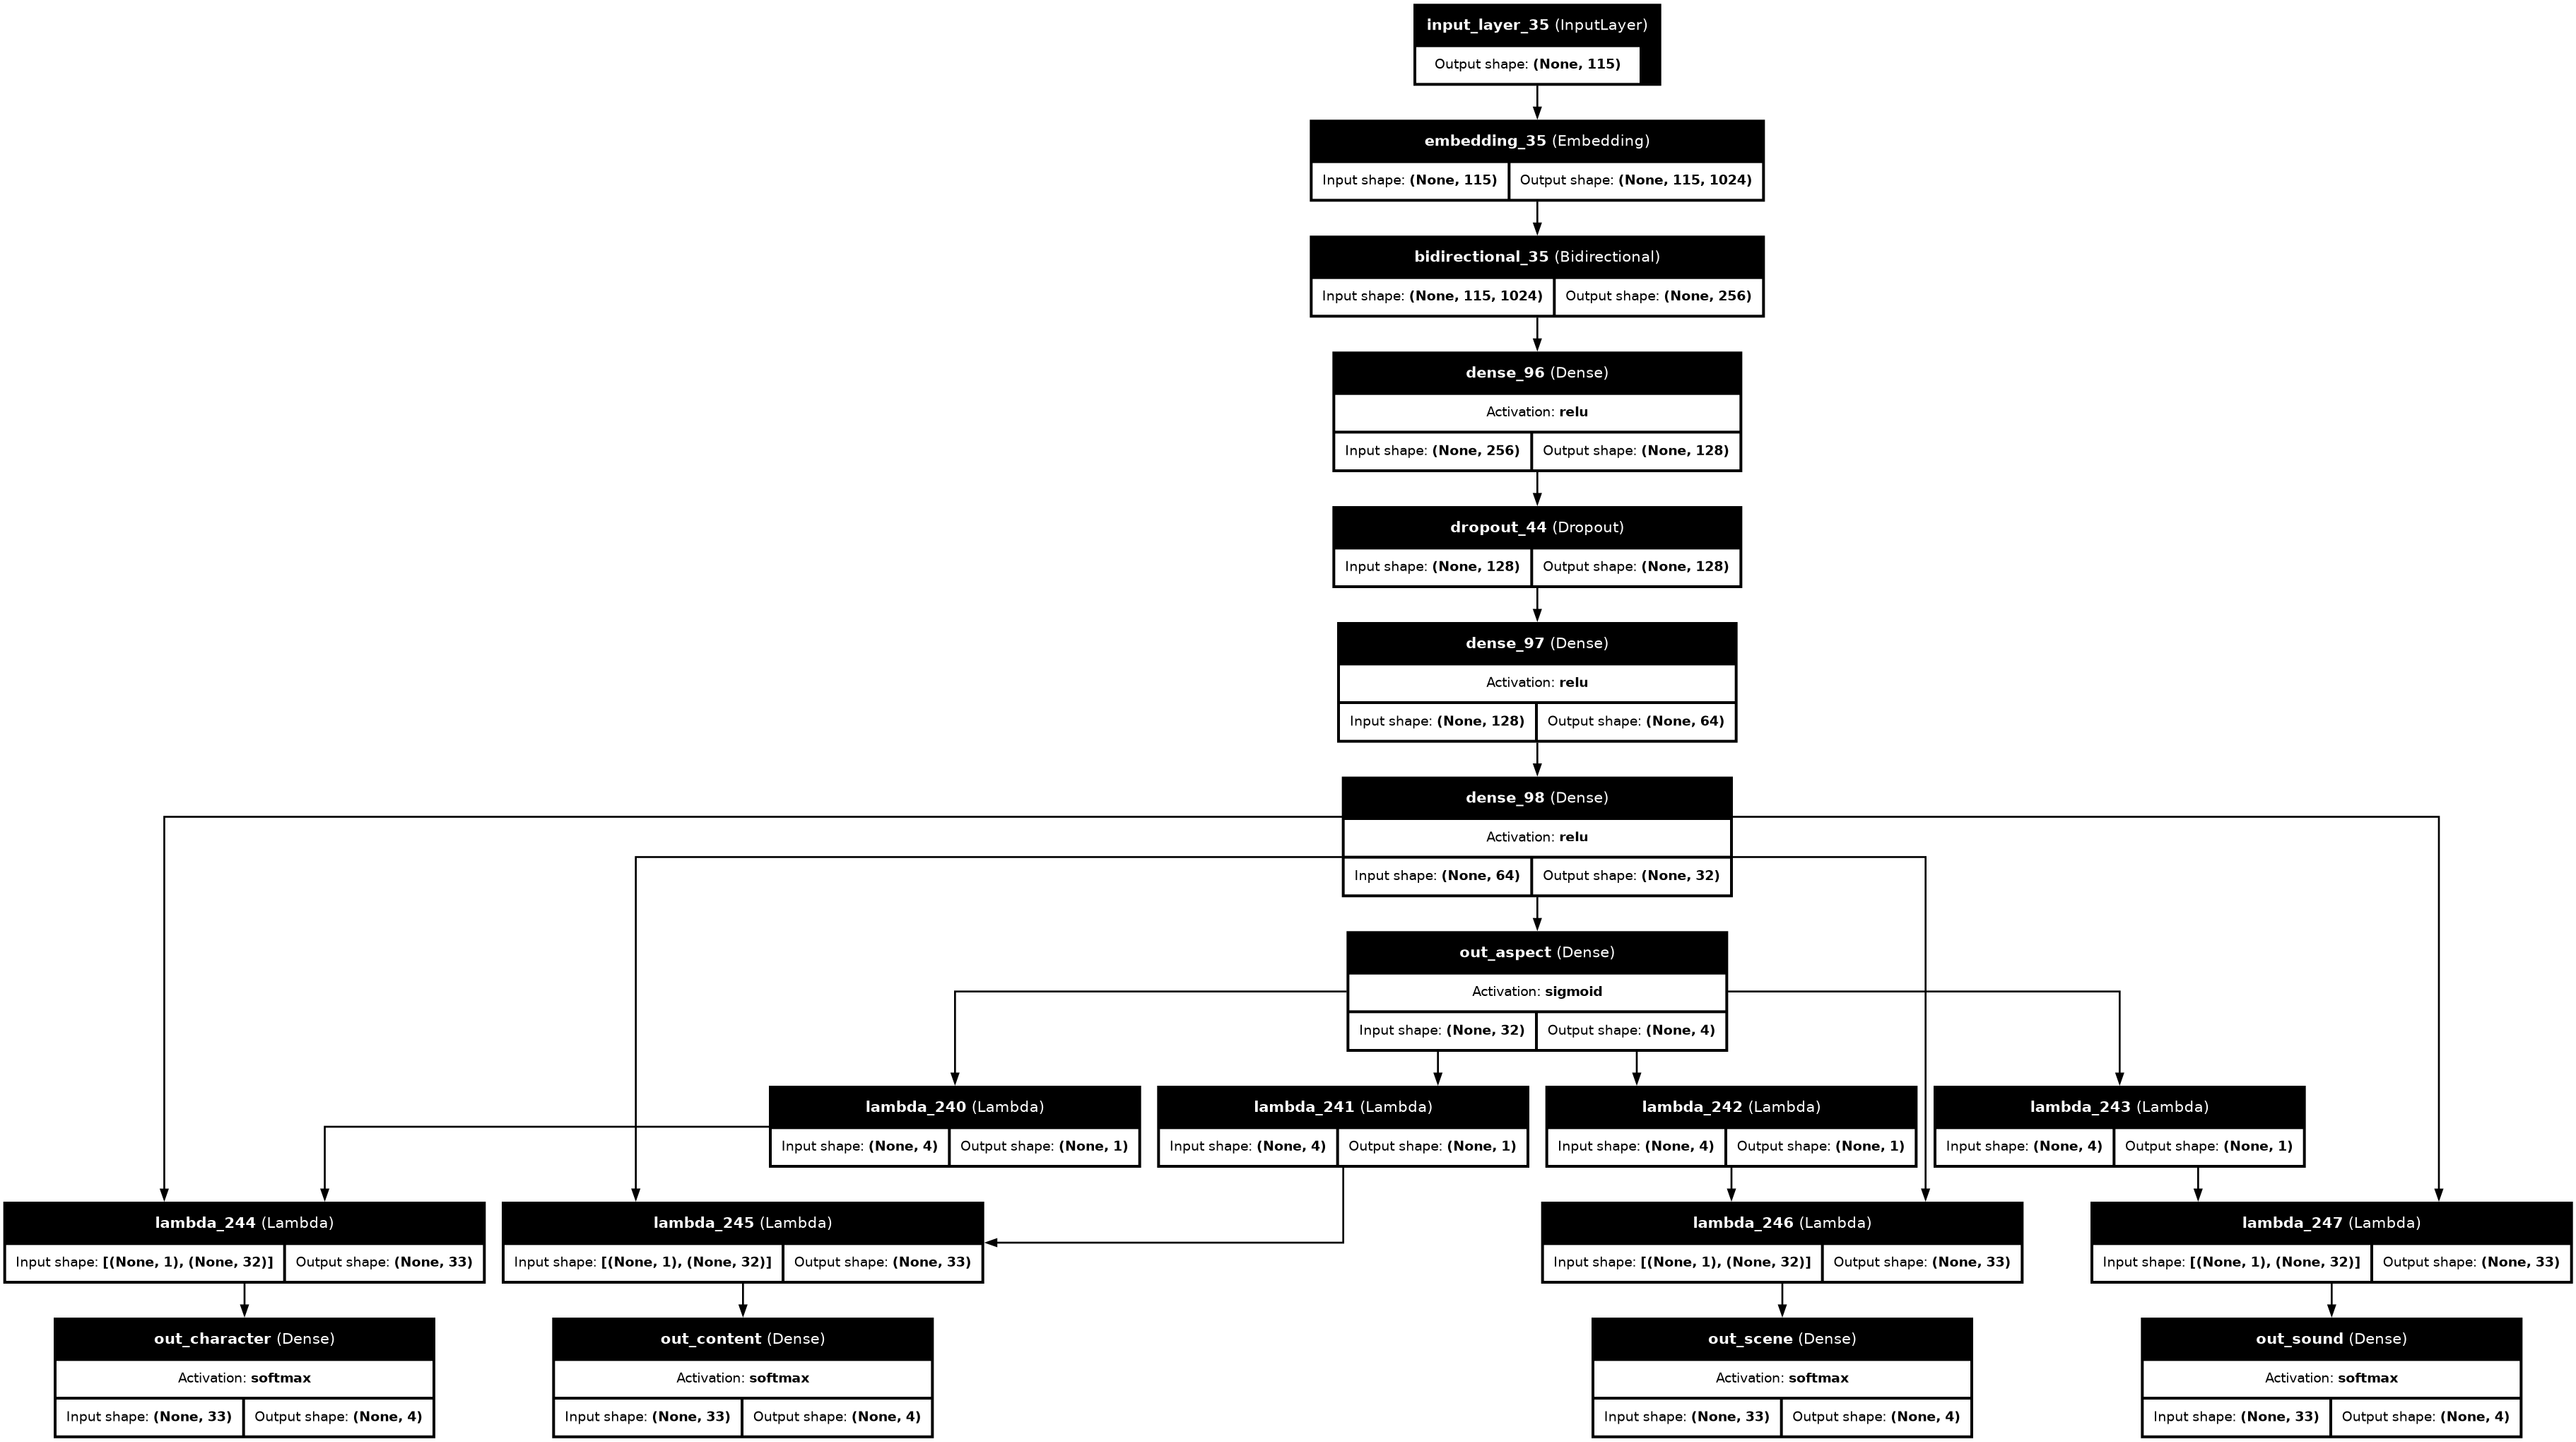

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Chuyển đổi các nhãn thành one-hot encoding cho từng loại đầu ra
y_character_train = to_categorical(character_train, 4)
y_content_train = to_categorical(content_train, 4)
y_scene_train = to_categorical(scene_train, 4)
y_sound_train = to_categorical(sound_train, 4)

y_character_val = to_categorical(character_val, 4)
y_content_val = to_categorical(content_val, 4)
y_scene_val = to_categorical(scene_val, 4)
y_sound_val = to_categorical(sound_val, 4)
print(y_character_val.shape)

# Huấn luyện mô hình
history = model.fit(
    x=padded_train,
    y={
        'out_character': y_character_train,
        'out_content': y_content_train,
        'out_scene': y_scene_train,
        'out_sound': y_sound_train
    },
    epochs=70,
    batch_size=128,
    validation_data=(
        padded_val,
        {
            'out_character': y_character_val,
            'out_content': y_content_val,
            'out_scene': y_scene_val,
            'out_sound': y_sound_val
        }
    ),
    verbose=1,
    callbacks=[callback]
)


(476, 4)
Epoch 1/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 17.0940 - out_character_accuracy: 0.5942 - out_content_accuracy: 0.5204 - out_scene_accuracy: 0.3609 - out_sound_accuracy: 0.4864 - val_loss: 7.5383 - val_out_character_accuracy: 0.6471 - val_out_content_accuracy: 0.5840 - val_out_scene_accuracy: 0.6912 - val_out_sound_accuracy: 0.7542
Epoch 2/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 6.2375 - out_character_accuracy: 0.6558 - out_content_accuracy: 0.6239 - out_scene_accuracy: 0.6747 - out_sound_accuracy: 0.7933 - val_loss: 3.9296 - val_out_character_accuracy: 0.6534 - val_out_content_accuracy: 0.6912 - val_out_scene_accuracy: 0.7164 - val_out_sound_accuracy: 0.8067
Epoch 3/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.6768 - out_character_accuracy: 0.6664 - out_content_accuracy: 0.6999 - out_scene_accuracy: 0.7151 - out_sound_accuracy: 0.8218 - val_loss: 3.2218 - val_out_character_accuracy: 0.7248 - val_out_content_accuracy: 0.6933 - val_out_scene_accur

In [ ]:
padded_train.shape

(3806, 115)

In [ ]:
out_content.shape

(None, 4)

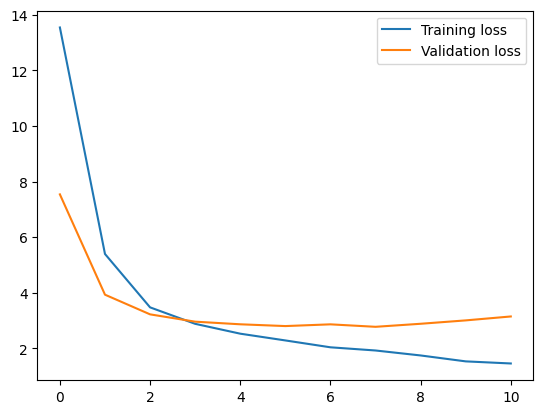

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

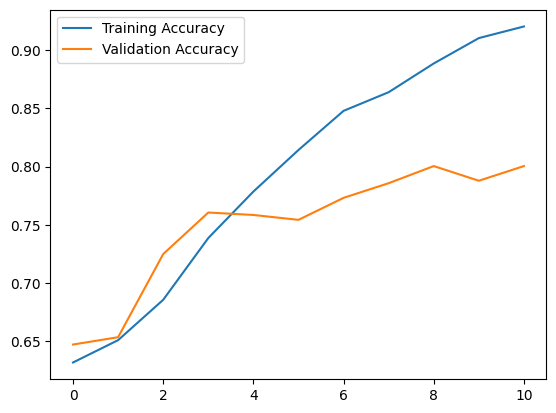

In [ ]:
plt.plot(history.history['out_character_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_out_character_accuracy'], label='Validation Accuracy')
plt.legend()

### Evaluation

In [ ]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [ ]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['character', 'content', 'scene', 'sound',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open(f'{path}/output_approach2/elmo_{model_type}_aspect_test_result.txt', "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))

    elif data_eval == 'eval':
        with open(f'{path}/output_approach2/elmo_{model_type}_aspect_val_result.txt', "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [ ]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bilstm')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bilstm')

In [ ]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [ ]:
pred_character_test = np.where(np.argmax(pred_test[0], axis = 1)==3, -1, np.argmax(pred_test[0], axis = 1))
pred_content_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_scene_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_sound_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))


In [ ]:
pred_character_val = np.where(np.argmax(pred_val[0], axis = 1)==3, -1, np.argmax(pred_val[0], axis = 1))
pred_content_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_scene_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_sound_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))



In [ ]:
predict_dict_test = {'character':pred_character_test, 'content':pred_content_test, 'scene': pred_scene_test,
                'sound': pred_sound_test}
predict_dict_val = {'character':pred_character_val, 'content': pred_content_val , 'scene': pred_scene_val,
                'sound': pred_sound_val}

In [ ]:
list_aspect = ['character', 'content', 'scene', 'sound']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(label_sentiment_test[f'{i}'], predict_dict_test[f'{i}']))
  print("-----------------------------------")


character

              precision    recall  f1-score   support

          -1       0.84      0.95      0.89       306
           0       0.66      0.43      0.52        54
           1       0.43      0.27      0.33        22
           2       0.72      0.60      0.66        95

    accuracy                           0.79       477
   macro avg       0.66      0.56      0.60       477
weighted avg       0.77      0.79      0.78       477

-----------------------------------
content

              precision    recall  f1-score   support

          -1       0.84      0.81      0.82       273
           0       0.21      0.10      0.14        40
           1       0.52      0.73      0.61        60
           2       0.50      0.52      0.51       104

    accuracy                           0.68       477
   macro avg       0.52      0.54      0.52       477
weighted avg       0.67      0.68      0.67       477

-----------------------------------
scene

              precision    reca

In [ ]:
list_aspect = ['character', 'content', 'scene', 'sound']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(label_sentiment_val[i], predict_dict_val[i]))
  print("-----------------------------------")

character

              precision    recall  f1-score   support

          -1       0.92      0.82      0.87       308
           0       0.51      0.55      0.53        47
           1       0.62      0.52      0.57        25
           2       0.59      0.78      0.67        96

    accuracy                           0.77       476
   macro avg       0.66      0.67      0.66       476
weighted avg       0.80      0.77      0.78       476

-----------------------------------
content

              precision    recall  f1-score   support

          -1       0.77      0.96      0.85       275
           0       0.18      0.05      0.07        43
           1       0.74      0.55      0.63        56
           2       0.66      0.53      0.59       102

    accuracy                           0.74       476
   macro avg       0.59      0.52      0.54       476
weighted avg       0.69      0.74      0.70       476

-----------------------------------
scene

              precision    reca

## BiGRU

In [ ]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 4
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)
# lstm = Bidirectional(GRU(units = 128, activation = 'tanh'))(embed)
lstm = Bidirectional(GRU(units=128,
                         activation='tanh',
                         recurrent_regularizer=l2(0.01)))(embed)


dense2 = Dense(units = 128, activation = 'relu')(lstm)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)
# lstm = Bidirectional(GRU(units=128, activation='tanh', recurrent_regularizer=l2(0.01)))(embed)

out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Lambda
import tensorflow as tf

# Hàm helper để lấy một cột từ tensor
def gather_aspect(index):
    def gather_fn(tensor):
        return tf.gather(tensor, [index], axis=1)
    return gather_fn

# Bọc tf.concat thành một Lambda layer
def concat_tensors(tensor1, tensor2):
    return tf.concat([tensor1, tensor2], axis=1)

# Các đầu ra con (character, content, scene, sound)
aspect_0 = Lambda(gather_aspect(0))(out_aspect)
aspect_1 = Lambda(gather_aspect(1))(out_aspect)
aspect_2 = Lambda(gather_aspect(2))(out_aspect)
aspect_3 = Lambda(gather_aspect(3))(out_aspect)

# Kết hợp và tạo các đầu ra
concat_character = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_0, dense4])
concat_content = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_1, dense4])
concat_scene = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_2, dense4])
concat_sound = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_3, dense4])

out_character = Dense(units=num_label, activation='softmax', name='out_character')(concat_character)
out_content = Dense(units=num_label, activation='softmax', name='out_content')(concat_content)
out_scene = Dense(units=num_label, activation='softmax', name='out_scene')(concat_scene)
out_sound = Dense(units=num_label, activation='softmax', name='out_sound')(concat_sound)

model = tf.keras.Model(inputs = input, outputs = [out_character, out_content, out_scene, out_sound])



In [ ]:
losses = {
	"out_character": "categorical_crossentropy",
	"out_content": "categorical_crossentropy",
  "out_scene": "categorical_crossentropy",
  "out_sound": "categorical_crossentropy",

}

In [ ]:
model.compile(
    optimizer='adam',
    loss={
        'out_character': 'categorical_crossentropy',
        'out_content': 'categorical_crossentropy',
        'out_scene': 'categorical_crossentropy',
        'out_sound': 'categorical_crossentropy'
    },
    metrics={
        'out_character': ['accuracy'],
        'out_content': ['accuracy'],
        'out_scene': ['accuracy'],
        'out_sound': ['accuracy']
    }
)


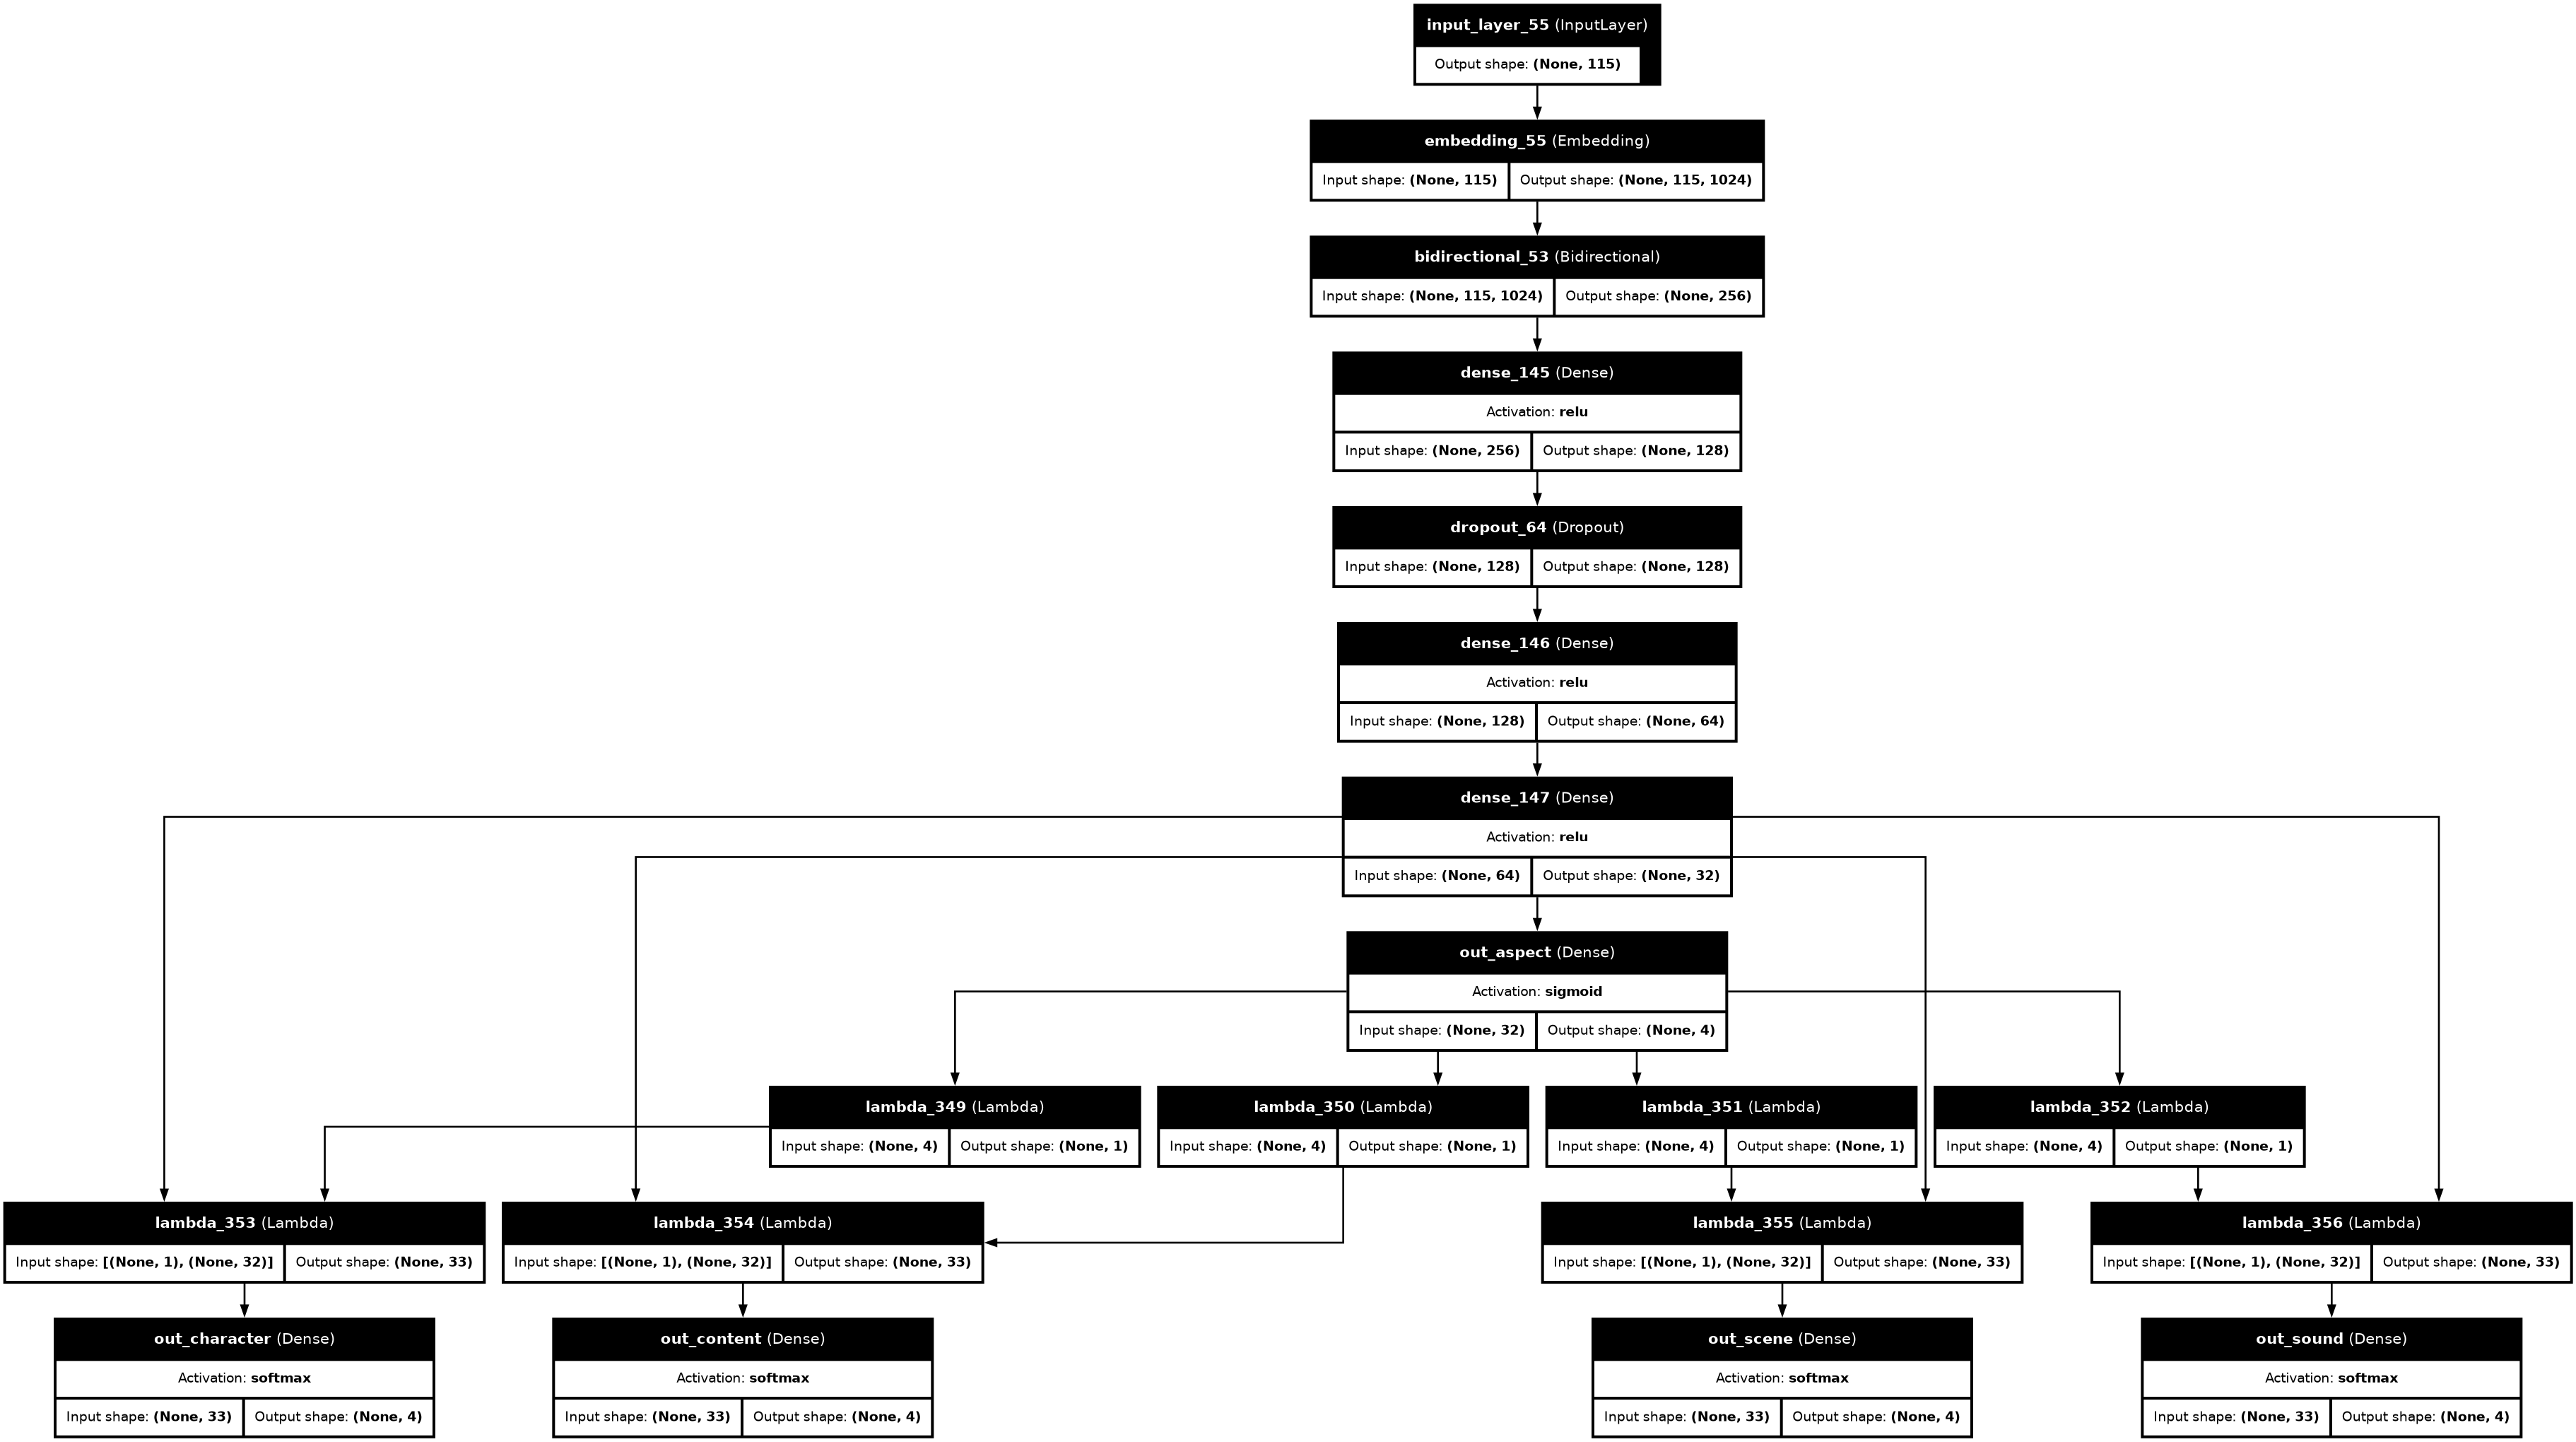

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Chuyển đổi các nhãn thành one-hot encoding cho từng loại đầu ra
y_character_train = to_categorical(character_train, 4)
y_content_train = to_categorical(content_train, 4)
y_scene_train = to_categorical(scene_train, 4)
y_sound_train = to_categorical(sound_train, 4)

y_character_val = to_categorical(character_val, 4)
y_content_val = to_categorical(content_val, 4)
y_scene_val = to_categorical(scene_val, 4)
y_sound_val = to_categorical(sound_val, 4)
print(y_character_val.shape)

# Huấn luyện mô hình
history = model.fit(
    x=padded_train,
    y={
        'out_character': y_character_train,
        'out_content': y_content_train,
        'out_scene': y_scene_train,
        'out_sound': y_sound_train
    },
    epochs=70,
    batch_size=128,
    validation_data=(
        padded_val,
        {
            'out_character': y_character_val,
            'out_content': y_content_val,
            'out_scene': y_scene_val,
            'out_sound': y_sound_val
        }
    ),
    verbose=1,
    callbacks=[callback]
)


(476, 4)
Epoch 1/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 6.9387 - out_character_accuracy: 0.5059 - out_content_accuracy: 0.4863 - out_scene_accuracy: 0.4446 - out_sound_accuracy: 0.4137 - val_loss: 4.6528 - val_out_character_accuracy: 0.6513 - val_out_content_accuracy: 0.5777 - val_out_scene_accuracy: 0.6933 - val_out_sound_accuracy: 0.7311
Epoch 2/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 4.3689 - out_character_accuracy: 0.6602 - out_content_accuracy: 0.6151 - out_scene_accuracy: 0.6759 - out_sound_accuracy: 0.7765 - val_loss: 3.7443 - val_out_character_accuracy: 0.6912 - val_out_content_accuracy: 0.5945 - val_out_scene_accuracy: 0.7080 - val_out_sound_accuracy: 0.7752
Epoch 3/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 3.5430 - out_character_accuracy: 0.6880 - out_content_accuracy: 0.6281 - out_scene_accuracy: 0.7047 - out_sound_accuracy: 0.7929 - val_loss: 3.4098 - val_out_character_accuracy: 0.7017 - val_out_content_accuracy: 0.6282 - val_out_scene_accura

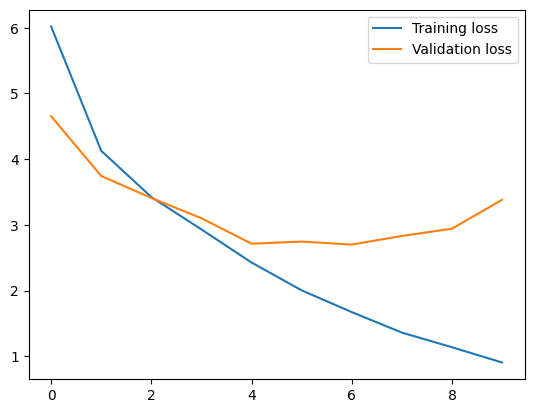

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

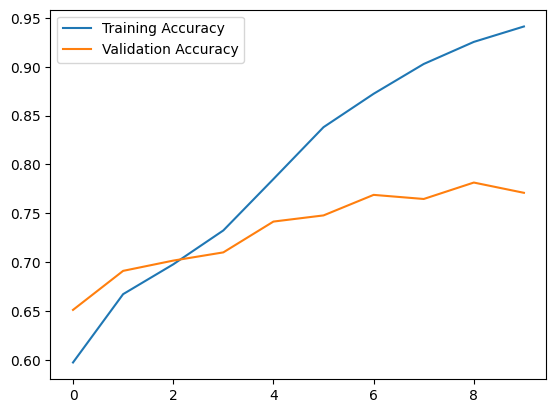

In [ ]:
plt.plot(history.history['out_character_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_out_character_accuracy'], label='Validation Accuracy')
plt.legend()

### Evaluation

In [ ]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['character', 'content', 'scene', 'sound',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open(f'{path}/output_approach2/elmo_{model_type}_aspect_test_result.txt', "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))

    elif data_eval == 'eval':
        with open(f'{path}/output_approach2/elmo_{model_type}_aspect_val_result.txt', "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [ ]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bigru')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bigru')

In [ ]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [ ]:
pred_character_test = np.where(np.argmax(pred_test[0], axis = 1)==3, -1, np.argmax(pred_test[0], axis = 1))
pred_content_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_scene_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_sound_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))


In [ ]:
pred_character_val = np.where(np.argmax(pred_val[0], axis = 1)==3, -1, np.argmax(pred_val[0], axis = 1))
pred_content_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_scene_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_sound_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))



In [ ]:
predict_dict_test = {'character':pred_character_test, 'content':pred_content_test, 'scene': pred_scene_test,
                'sound': pred_sound_test}
predict_dict_val = {'character':pred_character_val, 'content': pred_content_val , 'scene': pred_scene_val,
                'sound': pred_sound_val}

In [ ]:
list_aspect = ['character', 'content', 'scene', 'sound']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(label_sentiment_test[i], predict_dict_test[i]))
  print("-----------------------------------")


character

              precision    recall  f1-score   support

          -1       0.87      0.92      0.90       306
           0       0.63      0.59      0.61        54
           1       0.57      0.36      0.44        22
           2       0.71      0.64      0.67        95

    accuracy                           0.81       477
   macro avg       0.69      0.63      0.66       477
weighted avg       0.80      0.81      0.80       477

-----------------------------------
content

              precision    recall  f1-score   support

          -1       0.82      0.90      0.86       273
           0       0.33      0.30      0.32        40
           1       0.61      0.42      0.50        60
           2       0.54      0.53      0.53       104

    accuracy                           0.71       477
   macro avg       0.58      0.54      0.55       477
weighted avg       0.69      0.71      0.70       477

-----------------------------------
scene

              precision    reca

In [ ]:
list_aspect = ['character', 'content', 'scene', 'sound']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(label_sentiment_val[i], predict_dict_val[i]))
  print("-----------------------------------")

character

              precision    recall  f1-score   support

          -1       0.83      0.94      0.88       308
           0       0.55      0.45      0.49        47
           1       0.65      0.44      0.52        25
           2       0.64      0.49      0.55        96

    accuracy                           0.77       476
   macro avg       0.67      0.58      0.61       476
weighted avg       0.75      0.77      0.76       476

-----------------------------------
content

              precision    recall  f1-score   support

          -1       0.79      0.90      0.84       275
           0       0.15      0.05      0.07        43
           1       0.66      0.38      0.48        56
           2       0.51      0.59      0.55       102

    accuracy                           0.70       476
   macro avg       0.53      0.48      0.48       476
weighted avg       0.66      0.70      0.67       476

-----------------------------------
scene

              precision    reca

## BiLSTM+CONV

In [ ]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 4
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)

dropout1 = SpatialDropout1D(0.2)(embed)

lstm = Bidirectional(LSTM(units = 128, activation = 'tanh', return_sequences = True))(dropout1)
conv = Conv1D(128, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(lstm)

avg_pool1 = GlobalAveragePooling1D()(conv)
max_pool1 = GlobalMaxPooling1D()(conv)


concat = Concatenate(axis=-1)([avg_pool1, max_pool1])

dense2 = Dense(units = 128, activation = 'relu')(concat)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)


out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Lambda
import tensorflow as tf

# Hàm helper để lấy một cột từ tensor
def gather_aspect(index):
    def gather_fn(tensor):
        return tf.gather(tensor, [index], axis=1)
    return gather_fn

# Bọc tf.concat thành một Lambda layer
def concat_tensors(tensor1, tensor2):
    return tf.concat([tensor1, tensor2], axis=1)

# Các đầu ra con (character, content, scene, sound)
aspect_0 = Lambda(gather_aspect(0))(out_aspect)
aspect_1 = Lambda(gather_aspect(1))(out_aspect)
aspect_2 = Lambda(gather_aspect(2))(out_aspect)
aspect_3 = Lambda(gather_aspect(3))(out_aspect)

# Kết hợp và tạo các đầu ra
concat_character = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_0, dense4])
concat_content = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_1, dense4])
concat_scene = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_2, dense4])
concat_sound = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_3, dense4])

out_character = Dense(units=num_label, activation='softmax', name='out_character')(concat_character)
out_content = Dense(units=num_label, activation='softmax', name='out_content')(concat_content)
out_scene = Dense(units=num_label, activation='softmax', name='out_scene')(concat_scene)
out_sound = Dense(units=num_label, activation='softmax', name='out_sound')(concat_sound)

model = tf.keras.Model(inputs = input, outputs = [out_character, out_content, out_scene, out_sound])



In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'out_character': 'categorical_crossentropy',
        'out_content': 'categorical_crossentropy',
        'out_scene': 'categorical_crossentropy',
        'out_sound': 'categorical_crossentropy'
    },
    metrics={
        'out_character': ['accuracy'],
        'out_content': ['accuracy'],
        'out_scene': ['accuracy'],
        'out_sound': ['accuracy']
    }
)

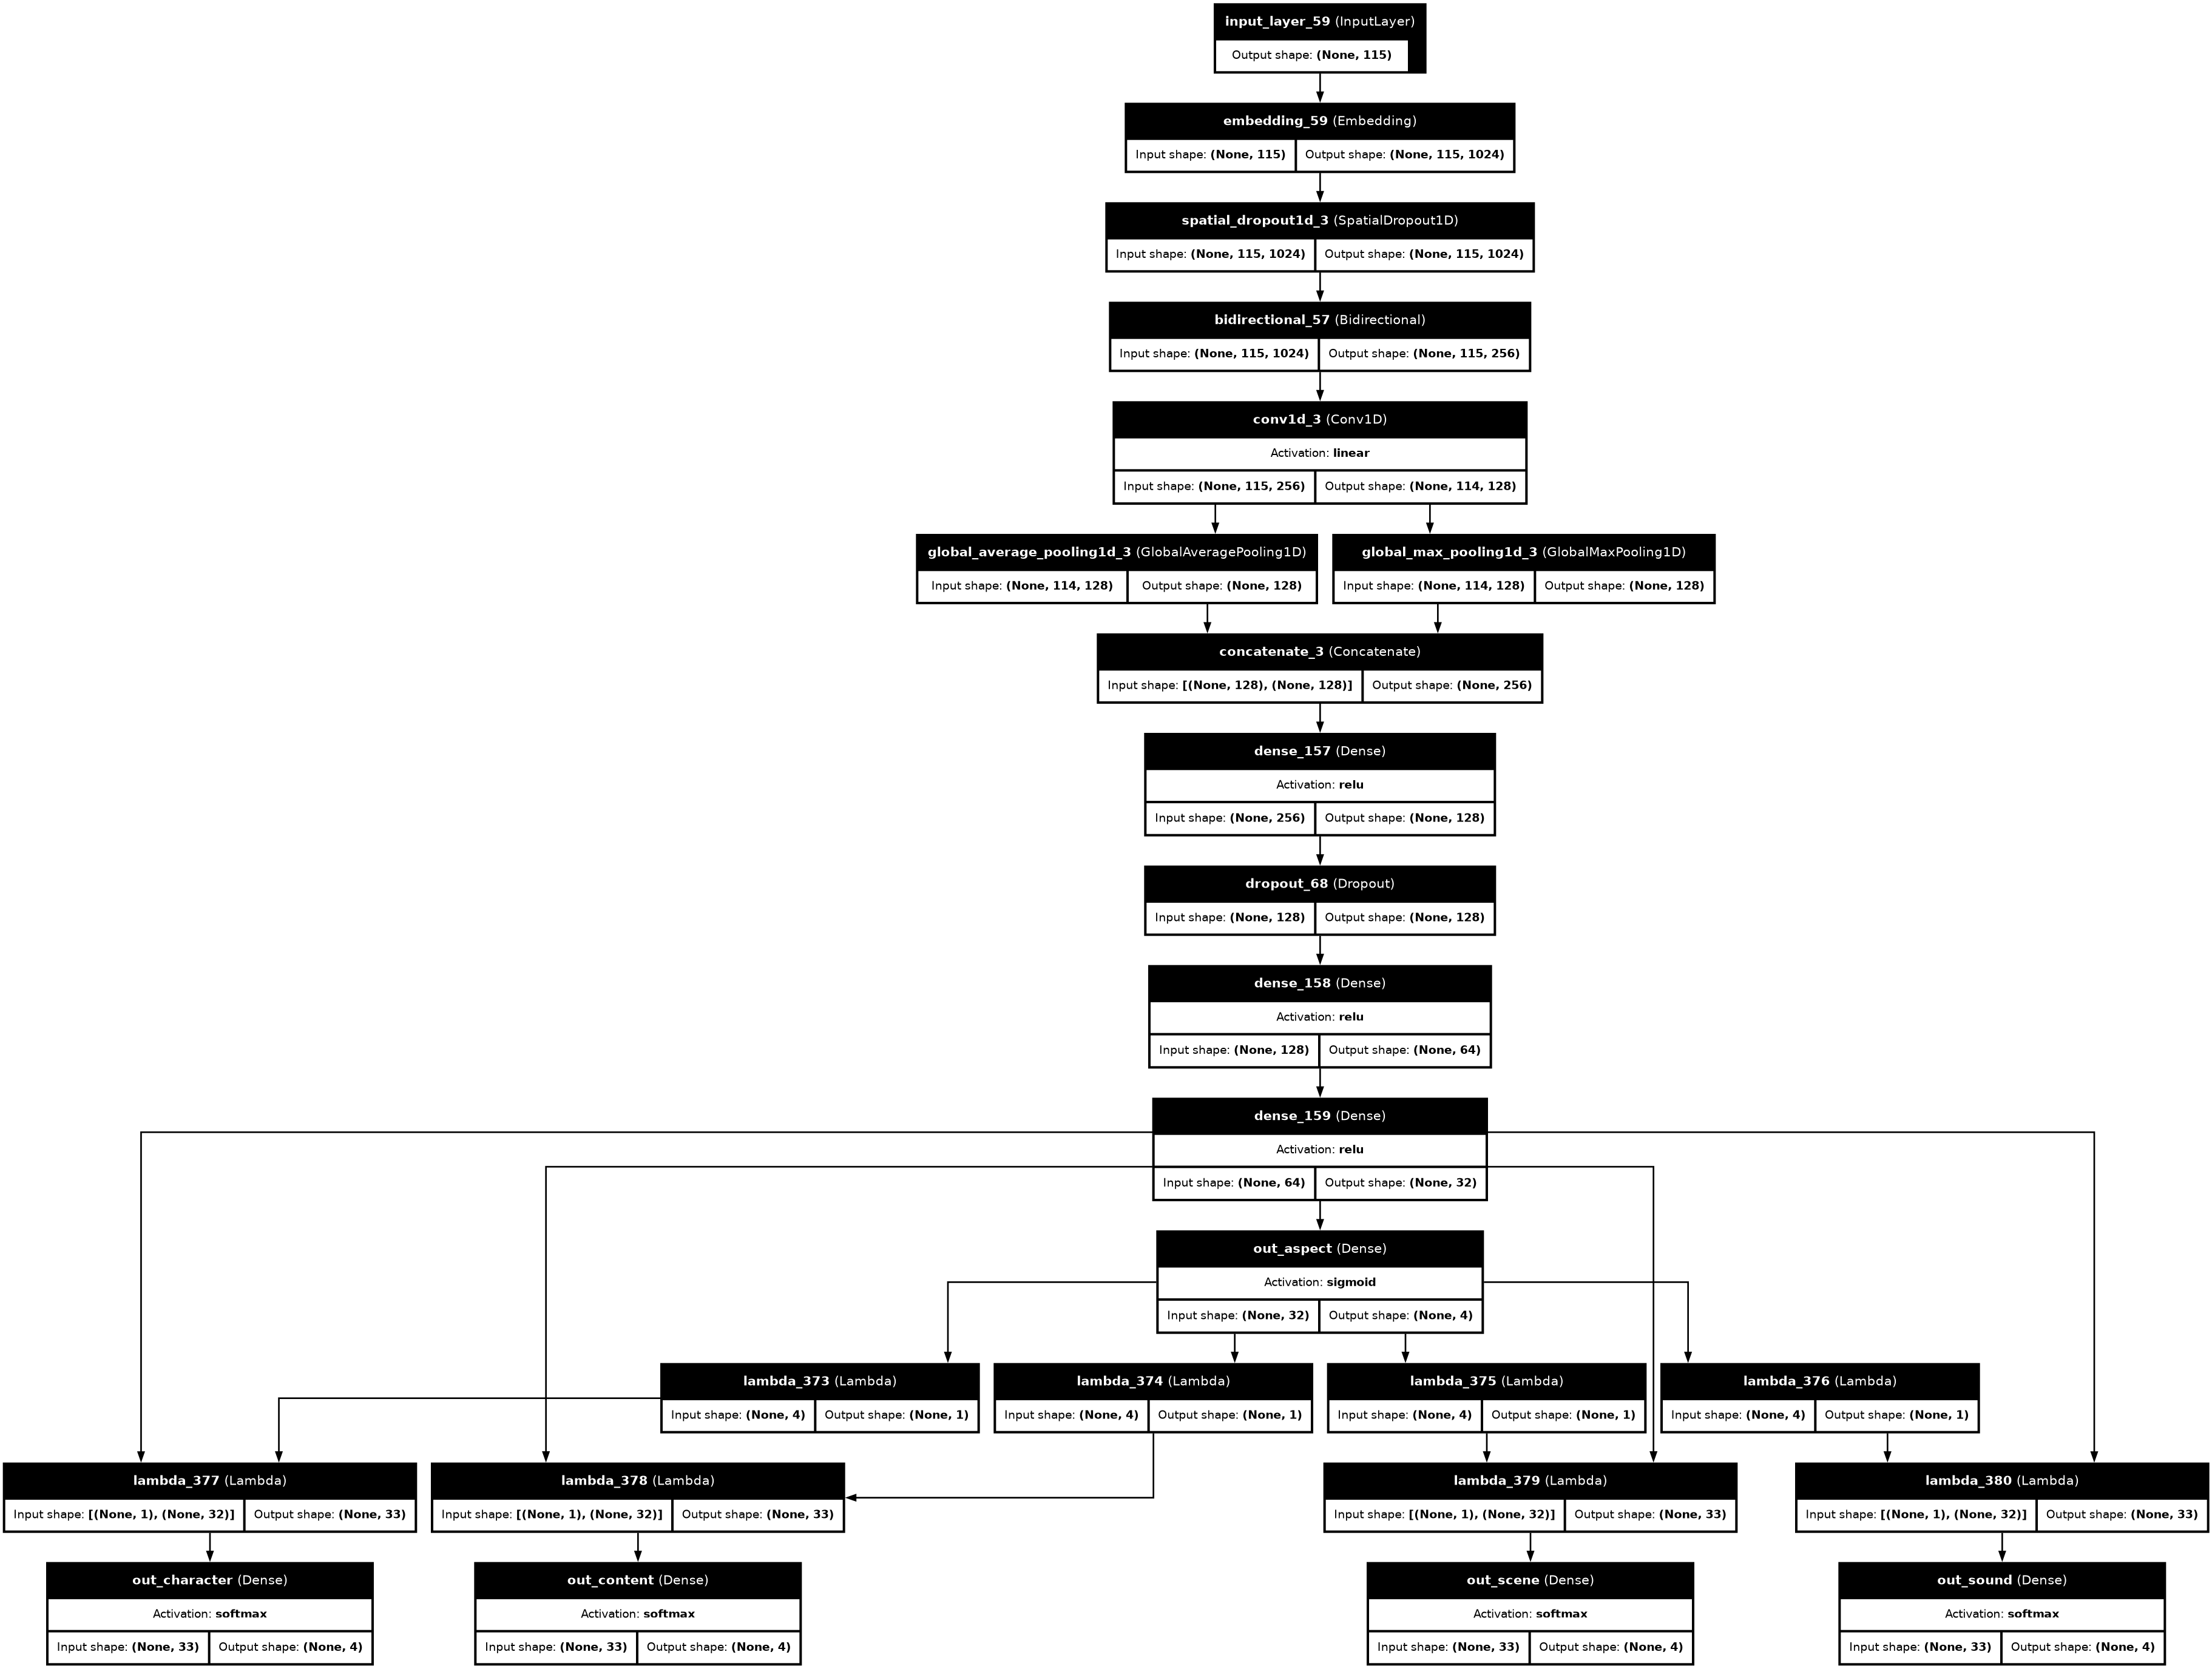

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Chuyển đổi các nhãn thành one-hot encoding cho từng loại đầu ra
y_character_train = to_categorical(character_train, 4)
y_content_train = to_categorical(content_train, 4)
y_scene_train = to_categorical(scene_train, 4)
y_sound_train = to_categorical(sound_train, 4)

y_character_val = to_categorical(character_val, 4)
y_content_val = to_categorical(content_val, 4)
y_scene_val = to_categorical(scene_val, 4)
y_sound_val = to_categorical(sound_val, 4)
print(y_character_val.shape)

# Huấn luyện mô hình
history = model.fit(
    x=padded_train,
    y={
        'out_character': y_character_train,
        'out_content': y_content_train,
        'out_scene': y_scene_train,
        'out_sound': y_sound_train
    },
    epochs=70,
    batch_size=128,
    validation_data=(
        padded_val,
        {
            'out_character': y_character_val,
            'out_content': y_content_val,
            'out_scene': y_scene_val,
            'out_sound': y_sound_val
        }
    ),
    verbose=1,
    callbacks=[callback]
)


(476, 4)
Epoch 1/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 4.5822 - out_character_accuracy: 0.5143 - out_content_accuracy: 0.4458 - out_scene_accuracy: 0.5474 - out_sound_accuracy: 0.5782 - val_loss: 3.2825 - val_out_character_accuracy: 0.6639 - val_out_content_accuracy: 0.6660 - val_out_scene_accuracy: 0.6849 - val_out_sound_accuracy: 0.7416
Epoch 2/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 3.2473 - out_character_accuracy: 0.6703 - out_content_accuracy: 0.6653 - out_scene_accuracy: 0.6750 - out_sound_accuracy: 0.7688 - val_loss: 2.7048 - val_out_character_accuracy: 0.7416 - val_out_content_accuracy: 0.6765 - val_out_scene_accuracy: 0.7164 - val_out_sound_accuracy: 0.8172
Epoch 3/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 2.6532 - out_character_accuracy: 0.7339 - out_content_accuracy: 0.7019 - out_scene_accuracy: 0.7110 - out_sound_accuracy: 0.8510 - val_loss: 2.3165 - val_out_character_accuracy: 0.7752 - val_out_content_accuracy: 0.7122 - val_out_scene_accur

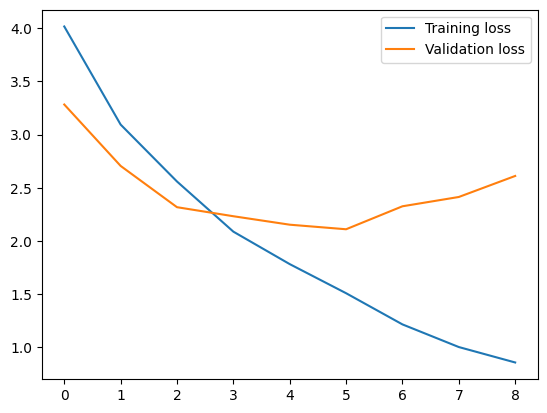

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

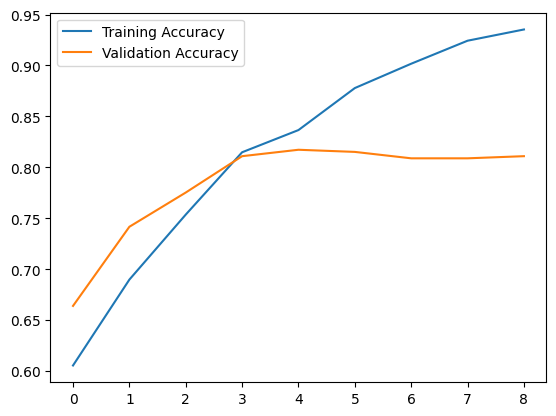

In [ ]:
plt.plot(history.history['out_character_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_out_character_accuracy'], label='Validation Accuracy')
plt.legend()

### Evaluation

In [ ]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['character', 'content', 'scene', 'sound',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open(f'{path}/output_approach2/elmo_{model_type}_aspect_test_result.txt', "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))

    elif data_eval == 'eval':
        with open(f'{path}/output_approach2/elmo_{model_type}_aspect_val_result.txt', "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [ ]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bilstm_conv')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bilstm_conv')

In [ ]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [ ]:
pred_character_test = np.where(np.argmax(pred_test[0], axis = 1)==3, -1, np.argmax(pred_test[0], axis = 1))
pred_content_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_scene_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_sound_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))


In [ ]:
pred_character_val = np.where(np.argmax(pred_val[0], axis = 1)==3, -1, np.argmax(pred_val[0], axis = 1))
pred_content_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_scene_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_sound_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))



In [ ]:
predict_dict_test = {'character':pred_character_test, 'content':pred_content_test, 'scene': pred_scene_test,
                'sound': pred_sound_test}
predict_dict_val = {'character':pred_character_val, 'content': pred_content_val , 'scene': pred_scene_val,
                'sound': pred_sound_val}

In [ ]:
list_aspect = ['character', 'content', 'scene', 'sound']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(label_sentiment_test[f'{i}'], predict_dict_test[f'{i}']))
  print("-----------------------------------")


character

              precision    recall  f1-score   support

          -1       0.87      0.94      0.90       306
           0       0.74      0.57      0.65        54
           1       0.50      0.23      0.31        22
           2       0.70      0.67      0.69        95

    accuracy                           0.82       477
   macro avg       0.70      0.60      0.64       477
weighted avg       0.80      0.82      0.80       477

-----------------------------------
content

              precision    recall  f1-score   support

          -1       0.83      0.86      0.85       273
           0       0.29      0.10      0.15        40
           1       0.59      0.50      0.54        60
           2       0.53      0.65      0.58       104

    accuracy                           0.71       477
   macro avg       0.56      0.53      0.53       477
weighted avg       0.69      0.71      0.69       477

-----------------------------------
scene

              precision    reca

## BiGRU+CONV

In [ ]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 4
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)

dropout1 = SpatialDropout1D(0.2)(embed)

lstm = Bidirectional(GRU(units = 128, activation = 'tanh', return_sequences = True))(dropout1)
conv = Conv1D(128, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(lstm)

avg_pool1 = GlobalAveragePooling1D()(conv)
max_pool1 = GlobalMaxPooling1D()(conv)


concat = Concatenate(axis=-1)([avg_pool1, max_pool1])

dense2 = Dense(units = 128, activation = 'relu')(concat)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)

# dense2 = Dense(units=64, activation='relu')(concat)
# dropout2 = Dropout(rate=0.2)(dense2)
# dense3 = Dense(units=32, activation='relu')(dropout2)
# dropout3 = Dropout(rate=0.2)(dense3)
# dense4 = Dense(units=16, activation='relu')(dropout3)


out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.regularizers import l2

import tensorflow as tf

# Hàm helper để lấy một cột từ tensor
def gather_aspect(index):
    def gather_fn(tensor):
        return tf.gather(tensor, [index], axis=1)
    return gather_fn

# Bọc tf.concat thành một Lambda layer
def concat_tensors(tensor1, tensor2):
    return tf.concat([tensor1, tensor2], axis=1)

# Các đầu ra con (character, content, scene, sound)
aspect_0 = Lambda(gather_aspect(0))(out_aspect)
aspect_1 = Lambda(gather_aspect(1))(out_aspect)
aspect_2 = Lambda(gather_aspect(2))(out_aspect)
aspect_3 = Lambda(gather_aspect(3))(out_aspect)

# Kết hợp và tạo các đầu ra
concat_character = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_0, dense4])
concat_content = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_1, dense4])
concat_scene = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_2, dense4])
concat_sound = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_3, dense4])

out_character = Dense(units=num_label, activation='softmax', name='out_character')(concat_character)
out_content = Dense(units=num_label, activation='softmax', name='out_content')(concat_content)
out_scene = Dense(units=num_label, activation='softmax', name='out_scene')(concat_scene)
out_sound = Dense(units=num_label, activation='softmax', name='out_sound')(concat_sound)

model = tf.keras.Model(inputs = input, outputs = [out_character, out_content, out_scene, out_sound])



In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'out_character': 'categorical_crossentropy',
        'out_content': 'categorical_crossentropy',
        'out_scene': 'categorical_crossentropy',
        'out_sound': 'categorical_crossentropy'
    },
    metrics={
        'out_character': ['accuracy'],
        'out_content': ['accuracy'],
        'out_scene': ['accuracy'],
        'out_sound': ['accuracy']
    }
)

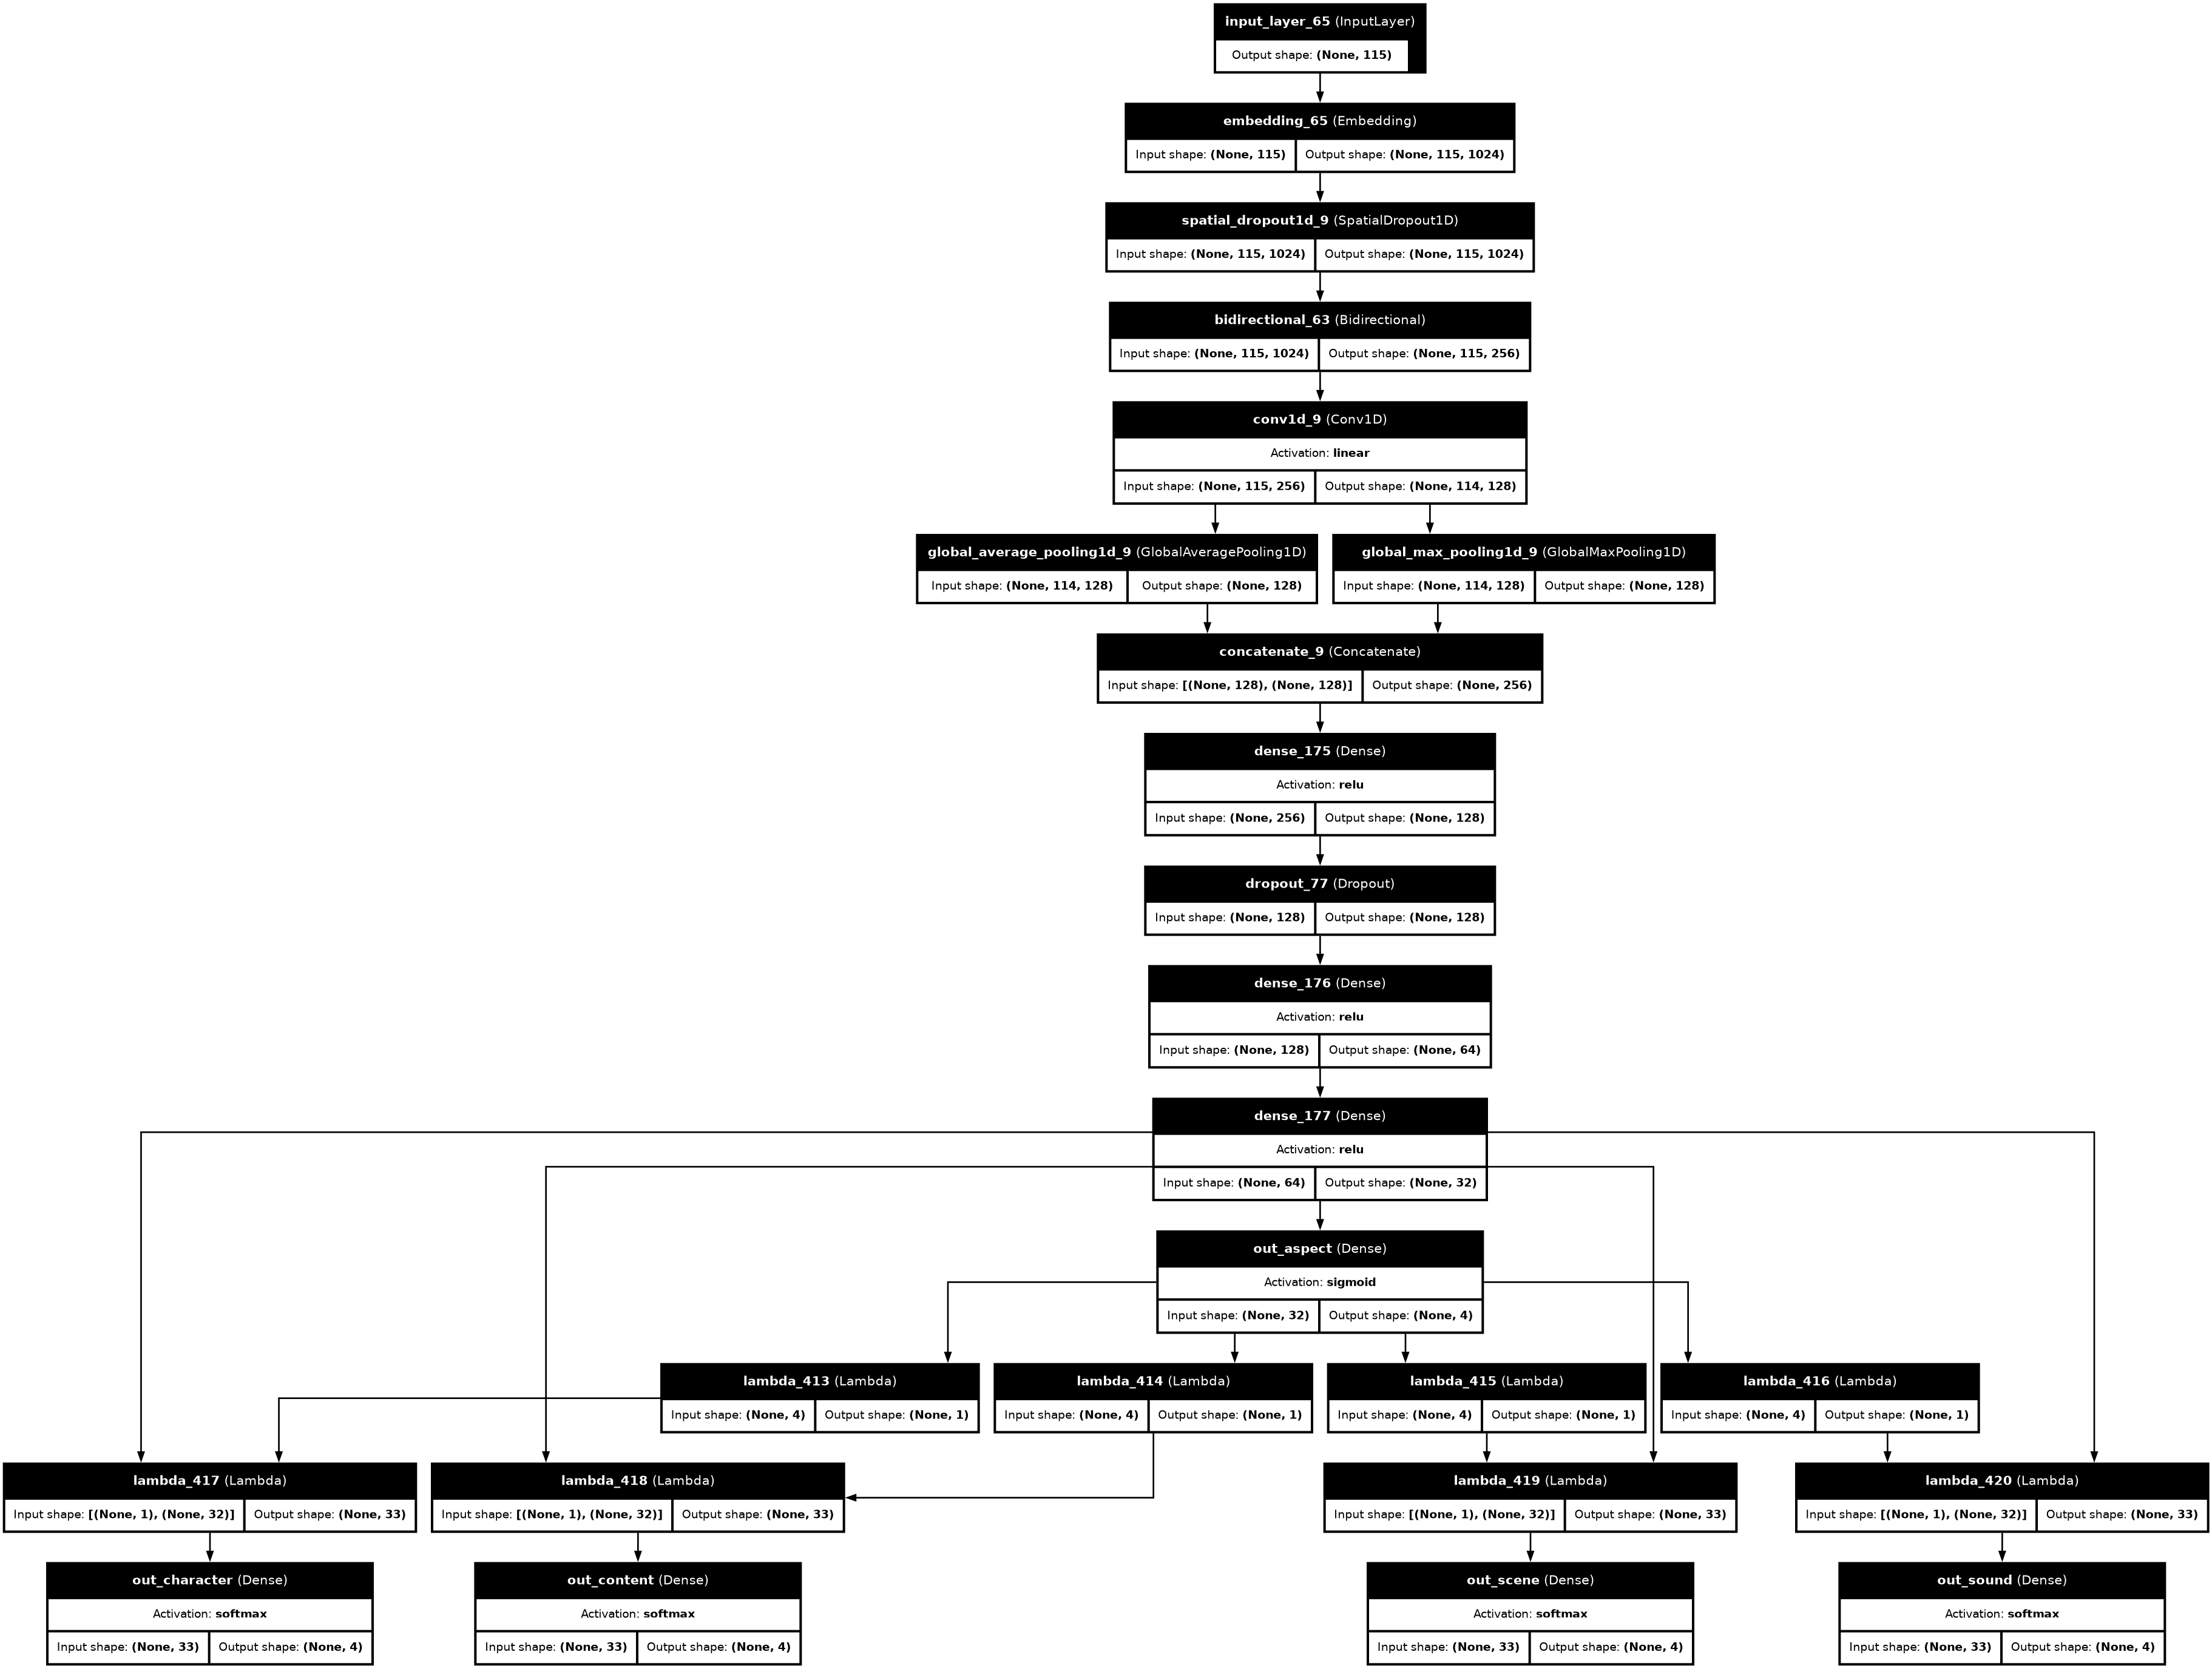

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Chuyển đổi các nhãn thành one-hot encoding cho từng loại đầu ra
y_character_train = to_categorical(character_train, 4)
y_content_train = to_categorical(content_train, 4)
y_scene_train = to_categorical(scene_train, 4)
y_sound_train = to_categorical(sound_train, 4)

y_character_val = to_categorical(character_val, 4)
y_content_val = to_categorical(content_val, 4)
y_scene_val = to_categorical(scene_val, 4)
y_sound_val = to_categorical(sound_val, 4)
print(y_character_val.shape)

# Huấn luyện mô hình
history = model.fit(
    x=padded_train,
    y={
        'out_character': y_character_train,
        'out_content': y_content_train,
        'out_scene': y_scene_train,
        'out_sound': y_sound_train
    },
    epochs=70,
    batch_size=128,
    validation_data=(
        padded_val,
        {
            'out_character': y_character_val,
            'out_content': y_content_val,
            'out_scene': y_scene_val,
            'out_sound': y_sound_val
        }
    ),
    verbose=1,
    callbacks=[callback]
)


(476, 4)
Epoch 1/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 4.5025 - out_character_accuracy: 0.6466 - out_content_accuracy: 0.4312 - out_scene_accuracy: 0.3909 - out_sound_accuracy: 0.7025 - val_loss: 3.1075 - val_out_character_accuracy: 0.6765 - val_out_content_accuracy: 0.6639 - val_out_scene_accuracy: 0.7017 - val_out_sound_accuracy: 0.7521
Epoch 2/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.0615 - out_character_accuracy: 0.7029 - out_content_accuracy: 0.6658 - out_scene_accuracy: 0.6916 - out_sound_accuracy: 0.7882 - val_loss: 2.4993 - val_out_character_accuracy: 0.7689 - val_out_content_accuracy: 0.6744 - val_out_scene_accuracy: 0.7521 - val_out_sound_accuracy: 0.8739
Epoch 3/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 2.4832 - out_character_accuracy: 0.7588 - out_content_accuracy: 0.6937 - out_scene_accuracy: 0.7412 - out_sound_accuracy: 0.8703 - val_loss: 2.2015 - val_out_character_accuracy: 0.8046 - val_out_content_accuracy: 0.6849 - val_out_scene_accura

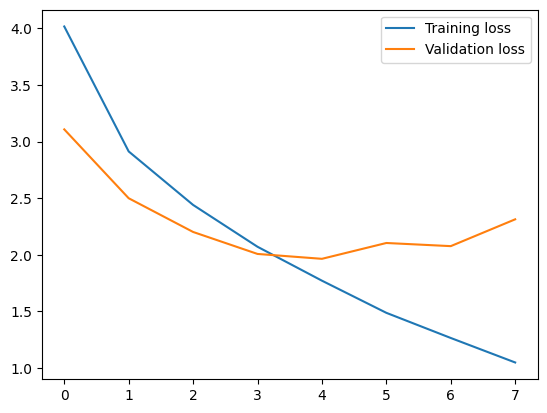

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

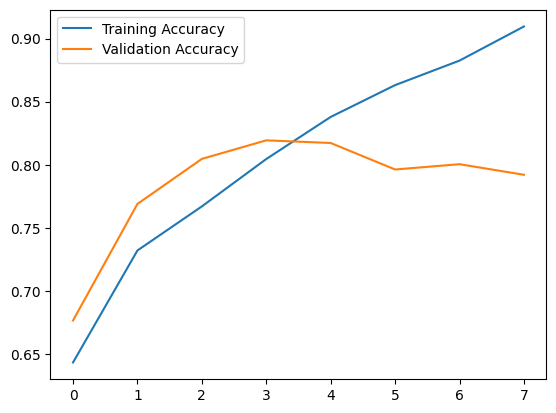

In [ ]:
plt.plot(history.history['out_character_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_out_character_accuracy'], label='Validation Accuracy')
plt.legend()

### Evaluation

In [ ]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['character', 'content', 'scene', 'sound',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open(f'{path}/output_approach2/elmo_{model_type}_aspect_test_result.txt', "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))

    elif data_eval == 'eval':
        with open(f'{path}/output_approach2/elmo_{model_type}_aspect_val_result.txt', "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [ ]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bigru_conv')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bigru_conv')

In [ ]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [ ]:
pred_character_test = np.where(np.argmax(pred_test[0], axis = 1)==3, -1, np.argmax(pred_test[0], axis = 1))
pred_content_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_scene_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_sound_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))


In [ ]:
pred_character_val = np.where(np.argmax(pred_val[0], axis = 1)==3, -1, np.argmax(pred_val[0], axis = 1))
pred_content_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_scene_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_sound_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))



In [ ]:
predict_dict_test = {'character':pred_character_test, 'content':pred_content_test, 'scene': pred_scene_test,
                'sound': pred_sound_test}
predict_dict_val = {'character':pred_character_val, 'content': pred_content_val , 'scene': pred_scene_val,
                'sound': pred_sound_val}

In [ ]:
list_aspect = ['character', 'content', 'scene', 'sound']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(label_sentiment_test[f'{i}'], predict_dict_test[f'{i}']))
  print("-----------------------------------")


character

              precision    recall  f1-score   support

          -1       0.89      0.92      0.90       306
           0       0.76      0.48      0.59        54
           1       0.50      0.27      0.35        22
           2       0.63      0.75      0.68        95

    accuracy                           0.81       477
   macro avg       0.69      0.61      0.63       477
weighted avg       0.80      0.81      0.80       477

-----------------------------------
content

              precision    recall  f1-score   support

          -1       0.86      0.84      0.85       273
           0       0.36      0.25      0.29        40
           1       0.63      0.60      0.62        60
           2       0.56      0.67      0.61       104

    accuracy                           0.72       477
   macro avg       0.60      0.59      0.59       477
weighted avg       0.72      0.72      0.72       477

-----------------------------------
scene

              precision    reca

## BiLSTM+BiGRU+CONV

In [ ]:
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
vocab_size = len(tok.word_index)+1
embedding_dim = 1024

max_len=padded_train.shape[1]
num_label = 4
# vocab size: the number of total of word in document
# output_dim: the out put matrix tend to 300
output_dim = 300


input = Input(shape=(max_len,))
embed = Embedding(input_dim=vocab_size,
                output_dim=embedding_dim,
                embeddings_initializer=Constant(embed_matrix),
                input_length=max_len,
                trainable=True)(input)

dropout1 = SpatialDropout1D(0.2)(embed)

lstm = Bidirectional(LSTM(units = 200, activation = 'tanh', return_sequences = True))(dropout1)
conv_lstm = Conv1D(128, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(lstm)

gru = Bidirectional(GRU(units = 200, activation = 'tanh', return_sequences = True))(dropout1)
conv_gru = Conv1D(128, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(gru)


avg_pool1 = GlobalAveragePooling1D()(conv_lstm)
max_pool1 = GlobalMaxPooling1D()(conv_lstm)

avg_pool2 = GlobalAveragePooling1D()(conv_gru)
max_pool2 = GlobalMaxPooling1D()(conv_gru)


concat = Concatenate(axis=-1)([avg_pool1, max_pool1, avg_pool2, max_pool2])
dense1 = Dense(units = 256, activation = 'relu')(concat)
dense2 = Dense(units = 128, activation = 'relu')(dense1)
dropout1 = Dropout(rate = 0.2)(dense2)
dense3 = Dense(units = 64, activation = 'relu')(dropout1)
dense4 = Dense(units = 32, activation = 'relu')(dense3)


out_aspect = Dense(units = num_label, activation = 'sigmoid', name='out_aspect')(dense4)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from tensorflow.keras.layers import Lambda
import tensorflow as tf

def gather_aspect(index):
    def gather_fn(tensor):
        return tf.gather(tensor, [index], axis=1)
    return gather_fn

def concat_tensors(tensor1, tensor2):
    return tf.concat([tensor1, tensor2], axis=1)

aspect_0 = Lambda(gather_aspect(0))(out_aspect)
aspect_1 = Lambda(gather_aspect(1))(out_aspect)
aspect_2 = Lambda(gather_aspect(2))(out_aspect)
aspect_3 = Lambda(gather_aspect(3))(out_aspect)

# Kết hợp và tạo các đầu ra
concat_character = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_0, dense4])
concat_content = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_1, dense4])
concat_scene = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_2, dense4])
concat_sound = Lambda(lambda x: concat_tensors(x[0], x[1]))([aspect_3, dense4])

out_character = Dense(units=num_label, activation='softmax', name='out_character')(concat_character)
out_content = Dense(units=num_label, activation='softmax', name='out_content')(concat_content)
out_scene = Dense(units=num_label, activation='softmax', name='out_scene')(concat_scene)
out_sound = Dense(units=num_label, activation='softmax', name='out_sound')(concat_sound)

model = tf.keras.Model(inputs = input, outputs = [out_character, out_content, out_scene, out_sound])



In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'out_character': 'categorical_crossentropy',
        'out_content': 'categorical_crossentropy',
        'out_scene': 'categorical_crossentropy',
        'out_sound': 'categorical_crossentropy'
    },
    metrics={
        'out_character': ['accuracy'],
        'out_content': ['accuracy'],
        'out_scene': ['accuracy'],
        'out_sound': ['accuracy']
    }
)

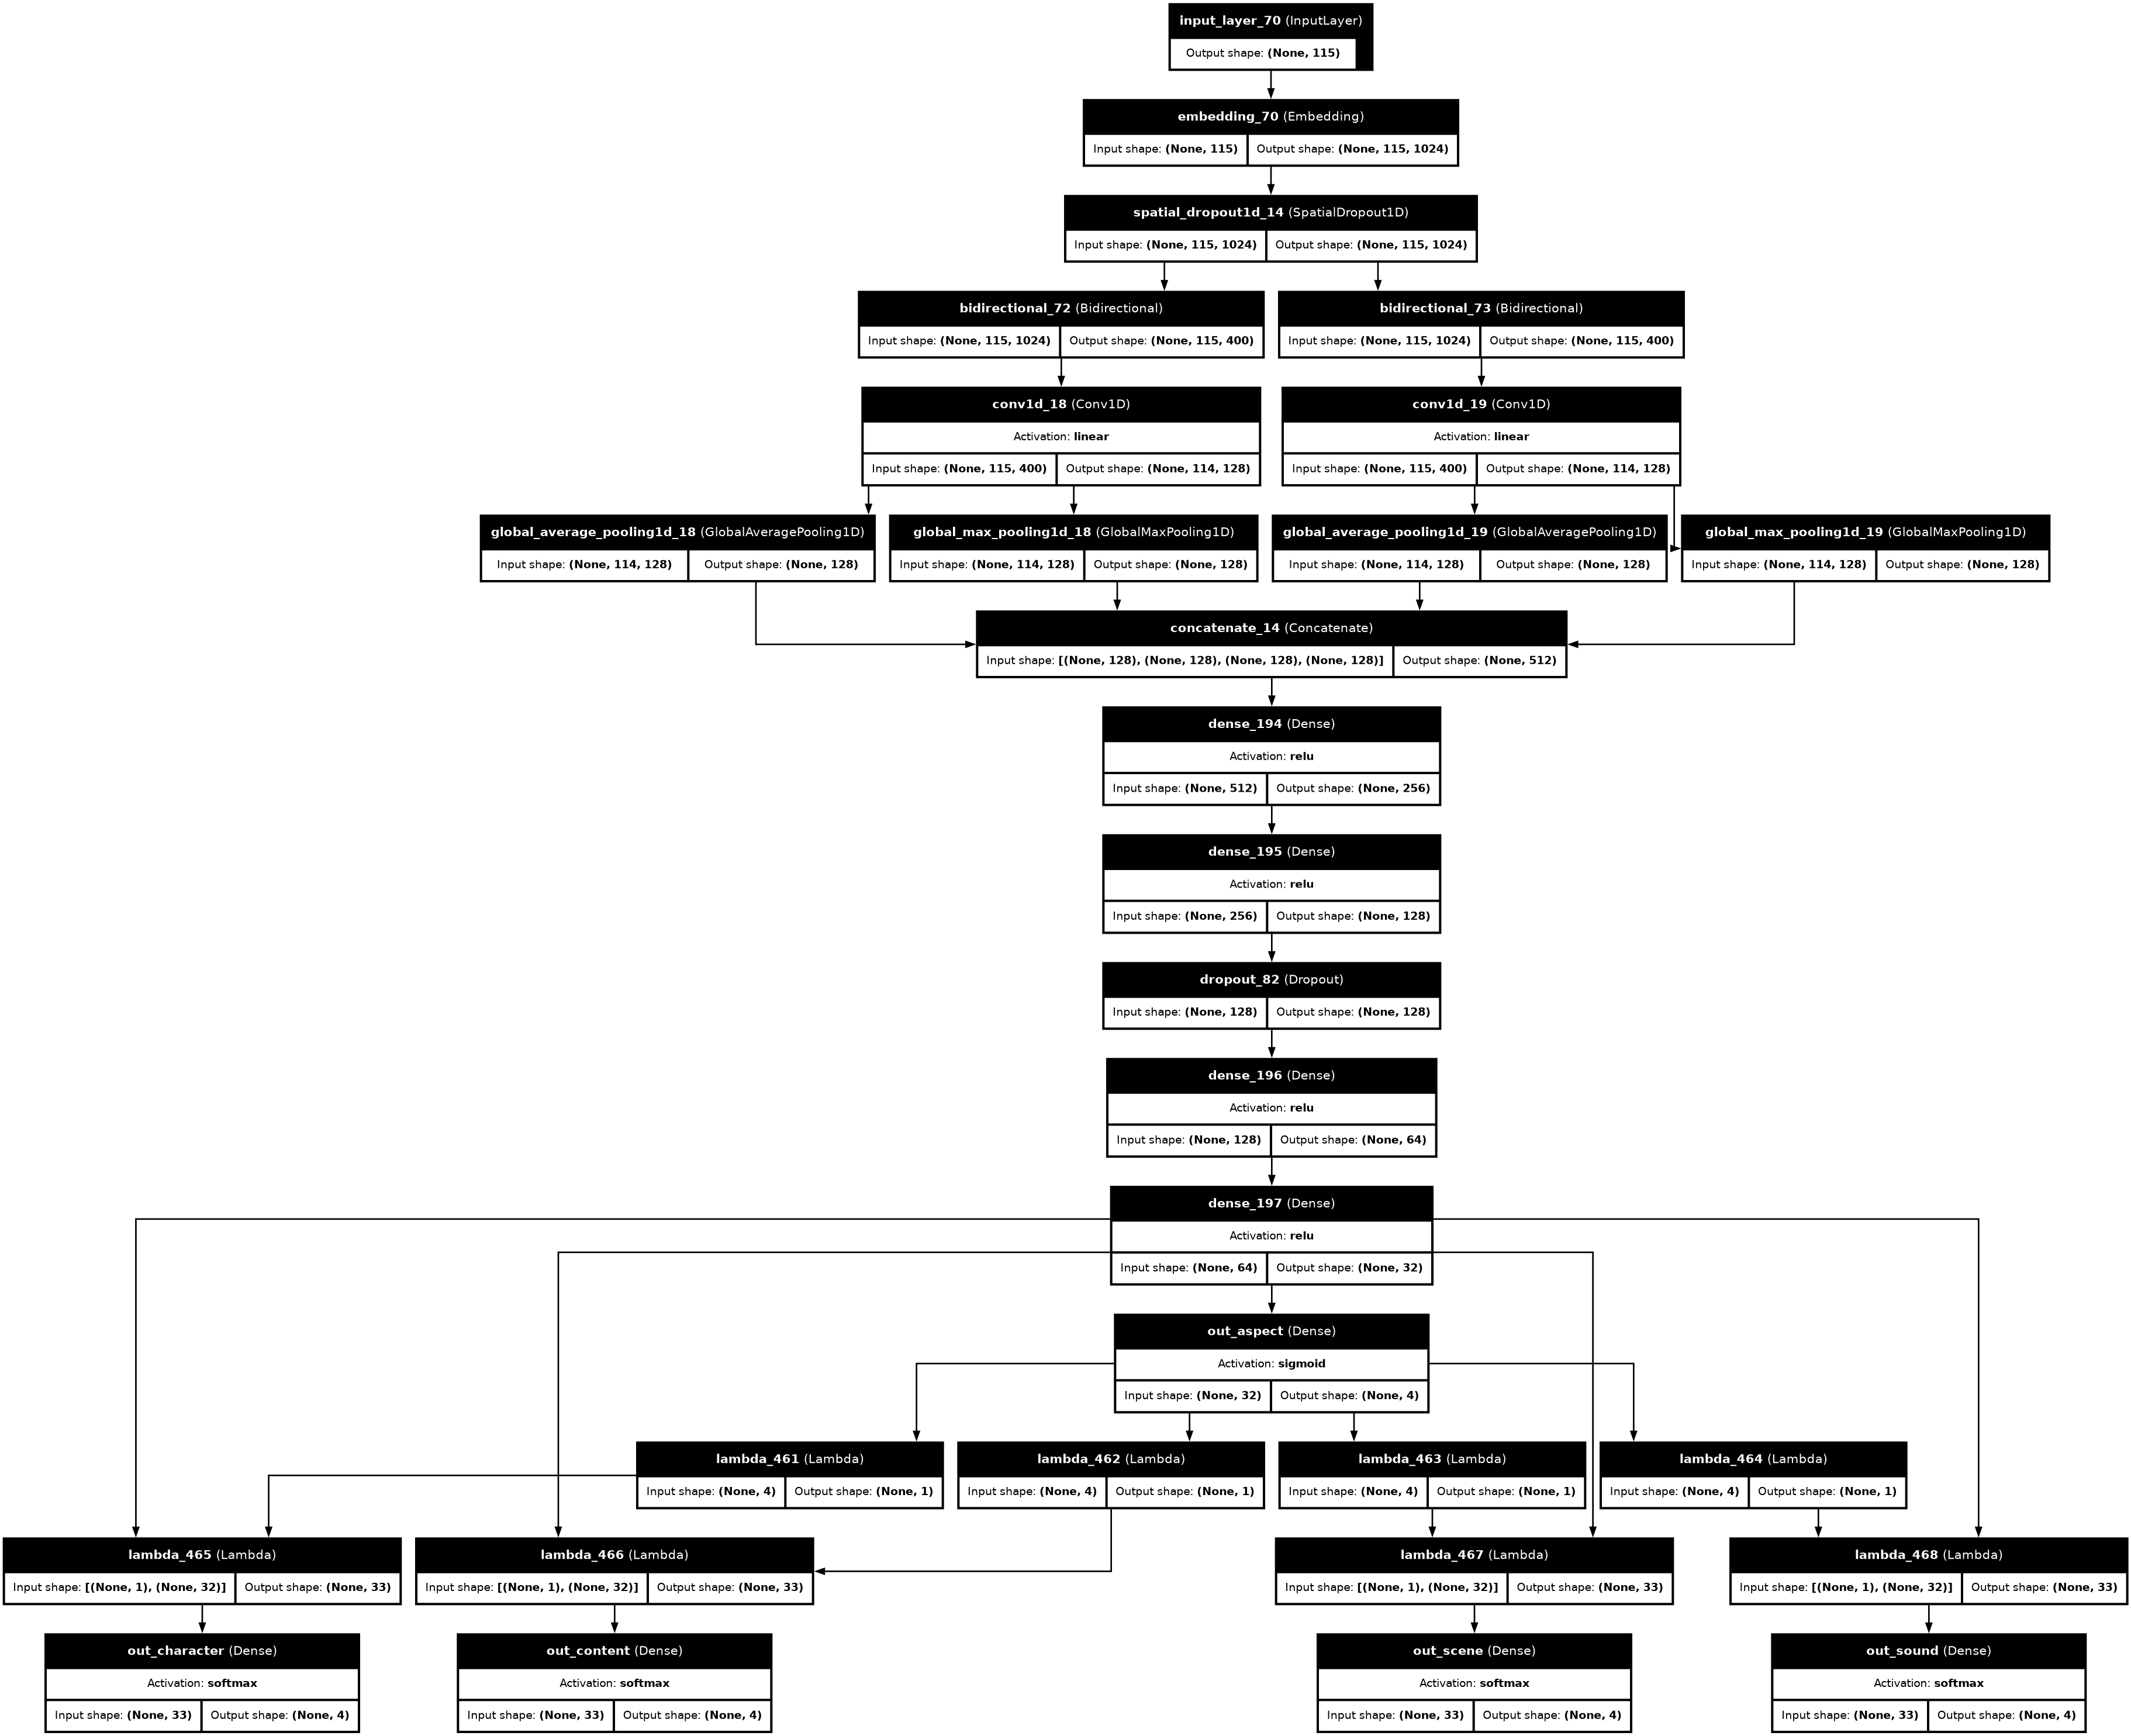

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=True
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Chuyển đổi các nhãn thành one-hot encoding cho từng loại đầu ra
y_character_train = to_categorical(character_train, 4)
y_content_train = to_categorical(content_train, 4)
y_scene_train = to_categorical(scene_train, 4)
y_sound_train = to_categorical(sound_train, 4)

y_character_val = to_categorical(character_val, 4)
y_content_val = to_categorical(content_val, 4)
y_scene_val = to_categorical(scene_val, 4)
y_sound_val = to_categorical(sound_val, 4)
print(y_character_val.shape)

# Huấn luyện mô hình
history = model.fit(
    x=padded_train,
    y={
        'out_character': y_character_train,
        'out_content': y_content_train,
        'out_scene': y_scene_train,
        'out_sound': y_sound_train
    },
    epochs=70,
    batch_size=128,
    validation_data=(
        padded_val,
        {
            'out_character': y_character_val,
            'out_content': y_content_val,
            'out_scene': y_scene_val,
            'out_sound': y_sound_val
        }
    ),
    verbose=1,
    callbacks= [callback]
)


(476, 4)
Epoch 1/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - loss: 5.2636 - out_character_accuracy: 0.4785 - out_content_accuracy: 0.1008 - out_scene_accuracy: 0.6640 - out_sound_accuracy: 0.2874 - val_loss: 4.5429 - val_out_character_accuracy: 0.6471 - val_out_content_accuracy: 0.4370 - val_out_scene_accuracy: 0.6849 - val_out_sound_accuracy: 0.7017
Epoch 2/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - loss: 4.3748 - out_character_accuracy: 0.6497 - out_content_accuracy: 0.4950 - out_scene_accuracy: 0.6527 - out_sound_accuracy: 0.7199 - val_loss: 3.7284 - val_out_character_accuracy: 0.6471 - val_out_content_accuracy: 0.6155 - val_out_scene_accuracy: 0.6849 - val_out_sound_accuracy: 0.7038
Epoch 3/70
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 3.7779 - out_character_accuracy: 0.6422 - out_content_accuracy: 0.6003 - out_scene_accuracy: 0.6607 - out_sound_accuracy: 0.7322 - val_loss: 3.3583 - val_out_character_accuracy: 0.6618 - val_out_content_accuracy: 0.6450 - val_out_scene_ac

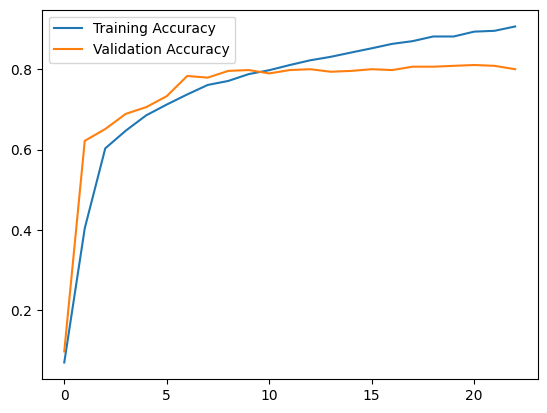

In [ ]:
plt.plot(history.history['out_character_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_out_character_accuracy'], label='Validation Accuracy')
plt.legend()

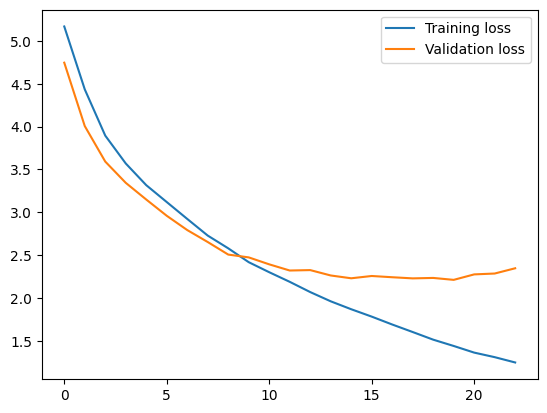

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

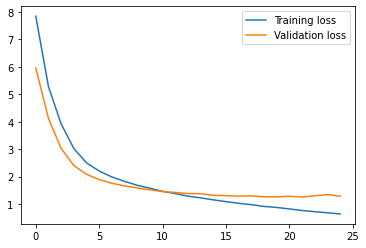

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

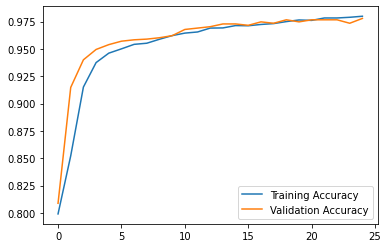

In [ ]:
plt.plot(history.history['out_character_acc'], label='Training Accuracy')
plt.plot(history.history['val_out_character_acc'], label='Validation Accuracy')
plt.legend()

In [ ]:
model.save('/kaggle/working/sentiment_BiLSTM_BiGRU_CONV.h5')
print("Model saved successfully!")

Model saved successfully!


### Evaluation

In [ ]:
pred_test = model.predict(padded_test)
pred_val = model.predict(padded_val)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
def save_result_pred_aspect(pred_aspect, true_aspect, data_eval, model_type):
  df_pred = round(pd.DataFrame(pred_aspect), 0)
  df_true = pd.DataFrame(true_aspect)
  for i, aspect in enumerate(['character', 'content', 'scene', 'sound',
                              'shipping', 'packing', 'stayingpower', 'others']):
    if data_eval == 'test':
      with open(f'{path}/output_approach2/elmo_{model_type}_aspect_test_result.txt', "a") as dest:
        dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
        dest.write(classification_report(df_true[i], df_pred[i]))

    elif data_eval == 'eval':
        with open(f'{path}/output_approach2/elmo_{model_type}_aspect_val_result.txt', "a") as dest:
          dest.write("Classification report for aspect: {} \n".format(aspect.upper()))
          dest.write(classification_report(df_true[i], df_pred[i]))
    else:
      raise('data eval is invalid')

In [ ]:
save_result_pred_aspect(pred_test[0], label_aspect_test, data_eval = 'test', model_type = 'bilstm_bigru_conv')
save_result_pred_aspect(pred_val[0], label_aspect_val, data_eval = 'eval', model_type = 'bilstm_bigru_conv')

In [ ]:
def extract_label_other(pred):
  pred_list = []
  for i in range(len(pred)):
    pred_list.append(round(pred[i][0], 0))
  return pred_list


In [ ]:
pred_character_test = np.where(np.argmax(pred_test[0], axis = 1)==3, -1, np.argmax(pred_test[0], axis = 1))
pred_content_test = np.where(np.argmax(pred_test[1], axis = 1)==3, -1, np.argmax(pred_test[1], axis = 1))
pred_scene_test = np.where(np.argmax(pred_test[2], axis = 1)==3, -1, np.argmax(pred_test[2], axis = 1))
pred_sound_test = np.where(np.argmax(pred_test[3], axis = 1)==3, -1, np.argmax(pred_test[3], axis = 1))


In [ ]:
pred_character_val = np.where(np.argmax(pred_val[0], axis = 1)==3, -1, np.argmax(pred_val[0], axis = 1))
pred_content_val = np.where(np.argmax(pred_val[1], axis = 1)==3, -1, np.argmax(pred_val[1], axis = 1))
pred_scene_val = np.where(np.argmax(pred_val[2], axis = 1)==3, -1, np.argmax(pred_val[2], axis = 1))
pred_sound_val = np.where(np.argmax(pred_val[3], axis = 1)==3, -1, np.argmax(pred_val[3], axis = 1))



In [ ]:
predict_dict_test = {'character':pred_character_test, 'content':pred_content_test, 'scene': pred_scene_test,
                'sound': pred_sound_test}
predict_dict_val = {'character':pred_character_val, 'content': pred_content_val , 'scene': pred_scene_val,
                'sound': pred_sound_val}

In [ ]:
list_aspect = ['character', 'content', 'scene', 'sound']
for i in list_aspect:
  print(i)
  print()
  print(classification_report(label_sentiment_test[f'{i}'], predict_dict_test[f'{i}']))
  print("-----------------------------------")


character

              precision    recall  f1-score   support

          -1       0.86      0.94      0.90       306
           0       0.72      0.48      0.58        54
           1       0.50      0.32      0.39        22
           2       0.65      0.63      0.64        95

    accuracy                           0.80       477
   macro avg       0.68      0.59      0.63       477
weighted avg       0.78      0.80      0.79       477

-----------------------------------
content

              precision    recall  f1-score   support

          -1       0.86      0.83      0.85       273
           0       0.20      0.03      0.04        40
           1       0.55      0.70      0.62        60
           2       0.52      0.66      0.58       104

    accuracy                           0.71       477
   macro avg       0.53      0.55      0.52       477
weighted avg       0.69      0.71      0.69       477

-----------------------------------
scene

              precision    reca

In [ ]:
# model.save('sentiment.h5')
# loaded_model = load_model('/kaggle/working/sentiment.h5')
# pickle.dump(model, open('save_model.sav', 'wb'))
loaded_model = pickle.load(open('save_model.sav', 'rb'))
result = loaded_model.score(label_sentiment_test[f'{i}'], predict_dict_test[f'{i}'])
print(result)

### Dự đoán

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ví dụ câu văn bản đầu vào
input_sentence = "Đây là một câu ví dụ để kiểm tra dự đoán."

# Tokenize câu
input_sequence = tok.texts_to_sequences([input_sentence])

# Padding câu để phù hợp với max_len
input_padded = pad_sequences(input_sequence, maxlen=max_len, padding='post')

print("Processed Input:", input_padded)


Processed Input: [[ 139    7   46  332 3221   24    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Tải mô hình đã lưu
loaded_model = load_model('/kaggle/working/sentiment_BiLSTM_BiGRU_CONV.h5')

# Dự đoán từ mô hình
predictions = loaded_model.predict(input_padded)

# Lấy nhãn dự đoán từ các đầu ra
out_character_pred = np.argmax(predictions['out_character'], axis=-1)[0]
out_content_pred = np.argmax(predictions['out_content'], axis=-1)[0]
out_scene_pred = np.argmax(predictions['out_scene'], axis=-1)[0]
out_sound_pred = np.argmax(predictions['out_sound'], axis=-1)[0]

# In kết quả dự đoán
print("Predicted Character Label:", out_character_pred)
print("Predicted Content Label:", out_content_pred)
print("Predicted Scene Label:", out_scene_pred)
print("Predicted Sound Label:", out_sound_pred)


TypeError: Could not locate function 'gather_fn'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'gather_fn', 'registered_name': 'function'}

In [ ]:
# Mapping nhãn (ví dụ)
label_mapping = {0: "Hành động", 1: "Hài", 2: "Kinh dị", 3: "Tình cảm"}

print("Predicted Character:", label_mapping[out_character_pred])
print("Predicted Content:", label_mapping[out_content_pred])
print("Predicted Scene:", label_mapping[out_scene_pred])
print("Predicted Sound:", label_mapping[out_sound_pred])
